# **Final Exam: Data Analysis and Processing Using Python**
**Universidad de la Sabana - Analítica de Datos**

***Jorge Esteban Diaz Bernal, Laura Camila rodriguez Leon, Carlos Augusto Sanchez Lombana***

El objetivo de este proyecto es desarrollar un modelo predictivo para estimar el ingreso laboral mensual a partir de microdatos de la Gran Encuesta Integrada de Hogares (GEIH) para los años 2021 a 2024, proporcionados por el DANE (Departamento Administrativo Nacional de Estadística). Esta encuesta ofrece información detallada sobre características demográficas, laborales y del hogar de la población colombiana.

### **Sección 1: Definición del problema y el Dataset**

#### Tarea de predicción

La tarea se plantea como un problema de regresión, donde la variable objetivo es el ingreso laboral mensual (P6500), expresado en pesos colombianos. Este valor refleja el total de ingresos reportados por la persona en su ocupación principal, y funciona como un indicador clave del bienestar económico individual.

#### Relevancia para el análisis de desigualdad y políticas públicas

El desarrollo de un modelo predictivo del ingreso laboral en Colombia, basado en los microdatos de la GEIH, ofrece una oportunidad concreta para entender las dinámicas estructurales de la desigualdad económica en el país. Este tipo de análisis permite ir más allá de las estadísticas descriptivas tradicionales, al identificar y cuantificar cómo distintas dimensiones —como la educación, la ocupación, el género, el territorio o el tipo de contrato— influyen en las oportunidades económicas de las personas. Al observar los factores que explican las diferencias salariales, es posible evidenciar barreras persistentes al bienestar que no responden únicamente al mérito o al esfuerzo individual, sino a condiciones sociales más amplias que reproducen desventajas históricas.

Los resultados de este modelo pueden aportar insumos valiosos para el diseño de políticas públicas más equitativas. Por ejemplo, al saber con mayor precisión qué perfiles se asocian con ingresos bajos, los responsables de política pueden orientar mejor los programas de formación laboral, subsidios o intervención social hacia los grupos que más lo necesitan. Además, permite evaluar el alcance real de políticas educativas y laborales implementadas en años recientes, al vincular directamente sus efectos con los niveles de ingreso. En última instancia, este tipo de enfoque fortalece la toma de decisiones basada en evidencia, promueve la focalización eficiente de recursos, y contribuye a la formulación de estrategias más eficaces para reducir la desigualdad y mejorar la movilidad social en el país.

#### Integración del dataset

Dado el volumen de archivos disponibles para cada año, se tomó una muestra estratégica de cuatro meses correspondientes al año 2024: febrero, julio, septiembre y diciembre. Esta selección permite cubrir diferentes ciclos estacionales y captar variabilidad en los ingresos.


**NOTA: para que esta celda se ejecute correctamente, se deben cargar los archivos Diciembre_2024.zip, Febrero_2024.zip, Julio_2024.zip, Septiembre_2024.zip en una carpeta local con el nombre exacto 'datos_zip' en el mismo directorio donde se ejecuta este script. El proceso de carga depende estrictamente de esta estructura. Si la carpeta no existe, o los nombres de los archivos están mal escritos, el proceso fallará.
Los datos se extraerán a una carpeta datos_extraidos/ y se cargarán automáticamente en un diccionario datos organizado por mes.**

In [168]:
import zipfile
from pathlib import Path
import joblib

# Análisis de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Estadística
from scipy import stats
from scipy.stats import f_oneway, kruskal, ttest_ind
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.weightstats import DescrStatsW, CompareMeans

# Modelado y evaluación
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_val_predict,
    cross_validate,
    KFold,
    RandomizedSearchCV
)
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (
    r2_score,
    explained_variance_score,
    mean_squared_error,
    mean_absolute_error,
    median_absolute_error,
    max_error,
    mean_absolute_percentage_error,
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve
)

# XGBoost
from xgboost import XGBRegressor, XGBClassifier


In [169]:


# 1. Definir rutas base
BASE_DIR = Path().resolve()
ZIP_DIR = BASE_DIR / "datos_zip"
EXTRAIDOS_DIR = BASE_DIR / "datos_extraidos"

# 2. Detectar ZIPs
zips = list(ZIP_DIR.glob("*.zip"))
print(f"Se encontraron {len(zips)} archivos ZIP en '{ZIP_DIR.name}'.")

# 3. Extraer si es necesario
for zip_path in zips:
    nombre_limpio = zip_path.stem.strip().replace(" ", "_").replace("__", "_").replace("1", "")
    destino = EXTRAIDOS_DIR / nombre_limpio

    if not destino.exists():
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(destino)
        print(f"✅ Extraído: {nombre_limpio}")
    else:
        print(f"🟡 Ya extraído: {nombre_limpio}")


# 4. Cargar CSVs detectando carpetas "CSV/" anidadas
datos = {}

for mes_dir in EXTRAIDOS_DIR.iterdir():
    if not mes_dir.is_dir():
        continue

    mes = mes_dir.name
    carpeta_csv = None

    # Buscar la carpeta "CSV" más profunda con archivos CSV dentro
    for subdir in mes_dir.rglob("CSV"):
        csvs = list(subdir.glob("*.csv"))
        if csvs:
            carpeta_csv = subdir
            break

    if carpeta_csv:
        archivos = list(carpeta_csv.glob("*.csv"))
        datos[mes] = {
            f.stem.strip(): pd.read_csv(f, encoding="latin1", sep=";", low_memory=False)
            for f in archivos
        }
        print(f"📁 {mes}: {len(datos[mes])} tablas cargadas")
    else:
        print(f"⚠️ No se encontraron archivos CSV en: {mes_dir}")


Se encontraron 4 archivos ZIP en 'datos_zip'.
🟡 Ya extraído: Diciembre_2024
🟡 Ya extraído: Febrero_2024
🟡 Ya extraído: Julio_2024
🟡 Ya extraído: Septiembre_2024
📁 Diciembre_2024: 8 tablas cargadas
📁 Febrero_2024: 8 tablas cargadas
📁 Julio_2024: 8 tablas cargadas
📁 Septiembre_2024: 8 tablas cargadas


Para cada uno de los meses seleccionados de la GEIH, se realiza un proceso de consolidación de información a partir de diferentes archivos temáticos. Cada archivo representa un aspecto específico de los hogares o de las personas encuestadas, tales como ocupación, características generales, migración, ingresos adicionales y condiciones de la vivienda. El primer paso consiste en extraer estos subconjuntos desde el diccionario datos, que organiza las tablas por mes, e identificar los principales DataFrames correspondientes a: personas ocupadas, otras formas de trabajo, características generales (que incluyen seguridad social y educación), datos del hogar, migración y otros ingresos.

Una vez identificados, se realiza una limpieza previa para evitar conflictos durante la fusión de los archivos. Esto se logra eliminando un conjunto de columnas repetidas o comunes entre los archivos, tales como CLASE, DPTO, PER, FEX_C18, REGIS, HOGAR, PERIODO, AREA y MES. Estas columnas, al estar presentes en múltiples archivos con posibles valores distintos, pueden generar ambigüedad o sobrescritura durante la combinación. Para ello, se utiliza una función auxiliar que elimina dichas columnas de cada DataFrame si están presentes.

Posteriormente, se lleva a cabo un proceso de unificación horizontal mediante merge(), en el cual se integran progresivamente todas las tablas temáticas, utilizando como claves principales las columnas DIRECTORIO, SECUENCIA_P y ORDEN, que identifican de manera única a cada persona en el hogar. Para la tabla de datos del hogar, que tiene información a nivel de vivienda y no de persona, la fusión se realiza usando únicamente DIRECTORIO y SECUENCIA_P. El resultado final es un único DataFrame por mes, que reúne toda la información relevante para cada individuo en una misma estructura, facilitando el análisis y modelado posterior. Al final, se inspeccionan sus dimensiones (shape) y su estructura interna (info()), para confirmar que los datos se han integrado correctamente.



FEBRERO

In [170]:
mes_febrero = datos["Febrero_2024"]
febrero_ocupados = mes_febrero["Ocupados"]
febrero_otras_formas_de_trabajo = mes_febrero["Otras formas de trabajo"]
febrero_caracteristicas_generales = mes_febrero["Características generales, seguridad social en salud y educación"]
febrero_datos_del_hogar = mes_febrero["Datos del hogar y la vivienda"]
febrero_migracion = mes_febrero["Migración"]
febrero_otros_ingresos_e_impuestos = mes_febrero["Otros ingresos e impuestos"]

# Columnas clave
columnas_clave = ['DIRECTORIO', 'SECUENCIA_P', 'ORDEN']

# Columnas repetidas que suelen causar conflicto
columnas_repetidas = ['CLASE', 'DPTO', 'PER', 'FEX_C18', 'REGIS', 'HOGAR', 'PERIODO', 'AREA', 'MES']

# Elimina estas columnas de los DataFrames antes del merge
def limpiar(df):
    return df.drop(columns=[col for col in columnas_repetidas if col in df.columns], errors='ignore')

# Limpiar dataframes
febrero_otras_formas_de_trabajo = limpiar(febrero_otras_formas_de_trabajo)
febrero_caracteristicas_generales = limpiar(febrero_caracteristicas_generales)
febrero_migracion = limpiar(febrero_migracion)
febrero_otros_ingresos_e_impuestos = limpiar(febrero_otros_ingresos_e_impuestos)

df_merged2 = febrero_ocupados.merge(febrero_otras_formas_de_trabajo, on=columnas_clave, how='left')
df_merged2 = df_merged2.merge(febrero_caracteristicas_generales, on=columnas_clave, how='left')
df_merged2 = df_merged2.merge(febrero_migracion, on=columnas_clave, how='left')
df_merged2 = df_merged2.merge(febrero_otros_ingresos_e_impuestos, on=columnas_clave, how='left')
df_merged2 = df_merged2.merge(febrero_datos_del_hogar, on=['DIRECTORIO', 'SECUENCIA_P'], how='left')

df_merged2.shape  # Número de filas y columnas
df_merged2.info()  # Tipos de datos y valores no nulos


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29943 entries, 0 to 29942
Columns: 479 entries, PERIODO_x to P6008
dtypes: float64(334), int64(120), object(25)
memory usage: 109.4+ MB


JULIO

In [171]:
mes_julio = datos["Julio_2024"]
julio_ocupados = mes_julio["Ocupados"]
julio_otras_formas_de_trabajo = mes_julio["Otras formas de trabajo"]
julio_caracteristicas_generales = mes_julio["Características generales, seguridad social en salud y educación"]
julio_datos_del_hogar = mes_julio["Datos del hogar y la vivienda"]
julio_migracion = mes_julio["Migración"]
julio_otros_ingresos_e_impuestos = mes_julio["Otros ingresos e impuestos"]

# Columnas clave
columnas_clave = ['DIRECTORIO', 'SECUENCIA_P', 'ORDEN']

# Columnas repetidas que suelen causar conflicto
columnas_repetidas = ['CLASE', 'DPTO', 'PER', 'FEX_C18', 'REGIS', 'HOGAR', 'PERIODO', 'AREA', 'MES']

# Elimina estas columnas de los DataFrames antes del merge
def limpiar(df):
    return df.drop(columns=[col for col in columnas_repetidas if col in df.columns], errors='ignore')

# Limpiar dataframes
julio_otras_formas_de_trabajo = limpiar(julio_otras_formas_de_trabajo)
julio_caracteristicas_generales = limpiar(julio_caracteristicas_generales)
julio_migracion = limpiar(julio_migracion)
julio_otros_ingresos_e_impuestos = limpiar(julio_otros_ingresos_e_impuestos)

df_merged7 = julio_ocupados.merge(julio_otras_formas_de_trabajo, on=columnas_clave, how='left')
df_merged7 = df_merged7.merge(julio_caracteristicas_generales, on=columnas_clave, how='left')
df_merged7 = df_merged7.merge(julio_migracion, on=columnas_clave, how='left')
df_merged7 = df_merged7.merge(julio_otros_ingresos_e_impuestos, on=columnas_clave, how='left')
df_merged7 = df_merged7.merge(julio_datos_del_hogar, on=['DIRECTORIO', 'SECUENCIA_P'], how='left')

df_merged7.shape  # Número de filas y columnas
df_merged7.info()  # Tipos de datos y valores no nulos


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29929 entries, 0 to 29928
Columns: 479 entries, PERIODO_x to P6008
dtypes: float64(334), int64(120), object(25)
memory usage: 109.4+ MB


SEPTIEMBRE

In [172]:
mes_septiembre = datos["Septiembre_2024"]
septiembre_ocupados = mes_septiembre["Ocupados"]
septiembre_otras_formas_de_trabajo = mes_septiembre["Otras formas de trabajo"]
septiembre_caracteristicas_generales = mes_septiembre["Características generales, seguridad social en salud y educación"]
septiembre_datos_del_hogar = mes_septiembre["Datos del hogar y la vivienda"]
septiembre_migracion = mes_septiembre["Migración"]
septiembre_otros_ingresos_e_impuestos = mes_septiembre["Otros ingresos e impuestos"]

# Columnas clave
columnas_clave = ['DIRECTORIO', 'SECUENCIA_P', 'ORDEN']

# Columnas repetidas que suelen causar conflicto
columnas_repetidas = ['CLASE', 'DPTO', 'PER', 'FEX_C18', 'REGIS', 'HOGAR', 'PERIODO', 'AREA', 'MES']

# Elimina estas columnas de los DataFrames antes del merge
def limpiar(df):
    return df.drop(columns=[col for col in columnas_repetidas if col in df.columns], errors='ignore')

# Limpiar dataframes
septiembre_otras_formas_de_trabajo = limpiar(septiembre_otras_formas_de_trabajo)
septiembre_caracteristicas_generales = limpiar(septiembre_caracteristicas_generales)
septiembre_migracion = limpiar(septiembre_migracion)
septiembre_otros_ingresos_e_impuestos = limpiar(septiembre_otros_ingresos_e_impuestos)

df_merged9 = septiembre_ocupados.merge(septiembre_otras_formas_de_trabajo, on=columnas_clave, how='left')
df_merged9 = df_merged9.merge(septiembre_caracteristicas_generales, on=columnas_clave, how='left')
df_merged9 = df_merged9.merge(septiembre_migracion, on=columnas_clave, how='left')
df_merged9 = df_merged9.merge(septiembre_otros_ingresos_e_impuestos, on=columnas_clave, how='left')
df_merged9 = df_merged9.merge(septiembre_datos_del_hogar, on=['DIRECTORIO', 'SECUENCIA_P'], how='left')

df_merged9.shape  # Número de filas y columnas
df_merged9.info()  # Tipos de datos y valores no nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29383 entries, 0 to 29382
Columns: 479 entries, PERIODO_x to P6008
dtypes: float64(334), int64(120), object(25)
memory usage: 107.4+ MB


DICIEMBRE

In [173]:
# DICIEMBRE
mes_diciembre = datos["Diciembre_2024"]
diciembre_ocupados = mes_diciembre["Ocupados"]
diciembre_otras_formas_de_trabajo = mes_diciembre["Otras formas de trabajo"]
diciembre_caracteristicas_generales = mes_diciembre["Características generales, seguridad social en salud y educación"]
diciembre_datos_del_hogar = mes_diciembre["Datos del hogar y la vivienda"]
diciembre_migracion = mes_diciembre["Migración"]
diciembre_otros_ingresos_e_impuestos = mes_diciembre["Otros ingresos e impuestos"]

# Columnas clave
columnas_clave = ['DIRECTORIO', 'SECUENCIA_P', 'ORDEN']

# Columnas repetidas que suelen causar conflicto
columnas_repetidas = ['CLASE', 'DPTO', 'PER', 'FEX_C18', 'REGIS', 'HOGAR', 'PERIODO', 'AREA', 'MES']

# Elimina estas columnas de los DataFrames antes del merge
def limpiar(df):
    return df.drop(columns=[col for col in columnas_repetidas if col in df.columns], errors='ignore')

# Limpiar dataframes
diciembre_otras_formas_de_trabajo = limpiar(diciembre_otras_formas_de_trabajo)
diciembre_caracteristicas_generales = limpiar(diciembre_caracteristicas_generales)
diciembre_migracion = limpiar(diciembre_migracion)
diciembre_otros_ingresos_e_impuestos = limpiar(diciembre_otros_ingresos_e_impuestos)

df_merged12 = diciembre_ocupados.merge(diciembre_otras_formas_de_trabajo, on=columnas_clave, how='left')
df_merged12 = df_merged12.merge(diciembre_caracteristicas_generales, on=columnas_clave, how='left')
df_merged12 = df_merged12.merge(diciembre_migracion, on=columnas_clave, how='left')
df_merged12 = df_merged12.merge(diciembre_otros_ingresos_e_impuestos, on=columnas_clave, how='left')
df_merged12 = df_merged12.merge(diciembre_datos_del_hogar, on=['DIRECTORIO', 'SECUENCIA_P'], how='left')

df_merged12.shape  # Número de filas y columnas
df_merged12.info()  # Tipos de datos y valores no nulos


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28154 entries, 0 to 28153
Columns: 479 entries, PERIODO_x to P6008
dtypes: float64(334), int64(120), object(25)
memory usage: 102.9+ MB


A continuación, se realiza la unificación de los datos provenientes de los meses seleccionados de la GEIH (febrero, julio, septiembre y diciembre de 2024). Para ello, se parte de cuatro DataFrames ya procesados individualmente: df_merged2, df_merged7, df_merged9 y df_merged12. Estos se agrupan en una lista llamada dfs, la cual se concatena utilizando la función pd.concat, que permite unir todos los registros en un único DataFrame denominado df_total. Al usar el parámetro ignore_index=True, se asegura que el nuevo DataFrame tenga un índice continuo, sin conservar los índices originales de cada fuente.

Una vez concatenados los datos, se revisó si había registros duplicados y se eliminaron para evitar errores en los análisis. También se reorganizó el índice de la tabla para que quedara limpio y ordenado. Al final, se mostró cuántos datos hay y un pequeño vistazo a las primeras filas, con el fin de verificar que la unión fue exitosa. Este paso es clave para garantizar que el análisis posterior se realice sobre una base de datos clara, coherente y sin errores.

ANUAL

In [174]:

# Lista de tus dataframes
dfs = [df_merged12, df_merged9, df_merged7, df_merged2]

# Concatenar, ignorando los índices originales y creando uno nuevo
df_total = pd.concat(dfs, ignore_index=True)

# comprobar que no hayas duplicado filas
df_total.drop_duplicates(inplace=True)

# resetear índice tras el drop_duplicates
df_total.reset_index(drop=True, inplace=True)

# Revisa el resultado
print(df_total.shape)
print(df_total.head())


(117409, 479)
   PERIODO_x  MES_x  PER_x  DIRECTORIO  SECUENCIA_P  ORDEN  HOGAR_x  REGIS_x  \
0   20241252     12   2024     8038184            1      1        1       60   
1   20241252     12   2024     8038186            1      2        1       60   
2   20241252     12   2024     8038187            1      1        1       60   
3   20241252     12   2024     8038188            1      2        1       60   
4   20241252     12   2024     8038189            1      1        1       60   

   AREA_x  CLASE_x  ...  P5222S3  P5222S4  P5222S5  P5222S6  P5222S7  P5222S8  \
0     NaN        2  ...      NaN      NaN      NaN      NaN      NaN      NaN   
1     NaN        2  ...      NaN      NaN      NaN      NaN      NaN      NaN   
2     NaN        2  ...      NaN      NaN      NaN      NaN      NaN      NaN   
3     NaN        2  ...      NaN      NaN      NaN      NaN      NaN      NaN   
4     NaN        2  ...      NaN      NaN      NaN      NaN      NaN      NaN   

   P5222S9  P5222S

#### Tratamiento de los datos

#### Selección de variables

Las variables explicativas fueron seleccionadas por su relevancia teórica en la determinación del ingreso, así como por su disponibilidad en la GEIH. Estas se agrupan en las siguientes categorías:

Socio-demográficas:

GENERO: Género de la persona.

EDAD: Edad en años cumplidos.

ETNIA: Autoidentificación étnica.

REGION: Macrozona geográfica.

CLASE: Zona urbana o rural de residencia.

Educativas:

MAXIMO_NIVEL_EDUCATIVO: Nivel educativo más alto alcanzado.

ACTUALMENTE_INSTITUCION: Tipo de institución educativa a la que asiste actualmente (si aplica).

Laborales:

OCUPACION: Código de ocupación según la clasificación CNO.

EXISTENCIA_CONTRATO: Indica si la persona tiene contrato laboral formal.

HORAS_TRABAJO: Número de horas trabajadas a la semana.

Del hogar y vivienda:

TAMANO_HOGAR: Número de personas que conforman el hogar.

ACCESO_SERVICIOS: Acceso a servicios públicos básicos como agua, electricidad o gas.

ESTRATO: Nivel socioeconómico asignado a la vivienda.

URBANO_RURAL: Clasificación del entorno de residencia (urbano o rural).

In [175]:

# 1) Diccionario de renombres
nombres_variables = {
    "P6040": "EDAD",
    "P3271": "SEXO_NACIMIENTO",
    "P3039": "GENERO",
    "P3038": "ATRACCION_POR",
    "P6080": "ETNIA",
    "P6080S1": "GRUPO_INDIGENA",
    "CLASE": "URBANO_RURAL",
    "P6160": "SABE_LEER",
    "P6170": "ACTUALMENTE_ESTUDIA",
    "P3041": "ACTUALMENTE_INSTITUCION",
    "P3042": "MAXIMO_NIVEL_EDUCATIVO",
    "P6500": "INGRESO",
    "OFICIO_C8": "OCUPACION",
    "P6800": "HORAS_TRABAJO",
    "P6430": "POSICION_OCUPACIONAL",
    "P6440": "EXISTENCIA_CONTRATO",
    "P6450": "CONTRATO_VERBAL_ESCRITO",
    "P6460": "TERMINO_CONTRATO",
    "RAMA2D_R4": "SECTOR_AMPLIO",
    "RAMA4D_R4": "SECTOR_DETALLADO",
    "P6008": "TOTAL_PERSONAS_HOGAR",
    "P6070": "ESTADO_CIVIL",
    "P6050": "PARENTESCO_CON_JEFE_HOGAR",
    "P4000": "TIPO_VIVIENDA",
    "P4030S1A1": "ESTRATO",
    "P5090": "TENENCIA_VIVIENDA",
    "P4030S1": "ELECTRICIDAD",
    "P4030S2": "GAS_NATURAL",
    "P4030S3": "ALCANTARILLADO",
    "P4030S5": "ACUEDUCTO",
    "P5050": "AGUA_POTABLE",
    "P5110": "VALOR_VIVIENDA",
    "P5140": "VALOR_ARRIENDO",
    "P3077S1A2": "LIMPIEZA_EN_SU_HOGAR_HORAS_DIA",
    "P3079S1A2": "CUIDADO_NINOS_SU_HOGAR_HORAS_DIA",
    "P3081S1A2": "CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA"
}

# 2) Columnas deseadas en el subset (sin ACTIVIDAD_MAYOR_TIEMPO)
cols_ingreso = [
    'DIRECTORIO', 'SECUENCIA_P', 'ORDEN', 'PARENTESCO_CON_JEFE_HOGAR',
    'INGRESO', 'FT', 'EDAD', 'SEXO_NACIMIENTO', 'GENERO', 'ATRACCION_POR',
    'ETNIA', 'CAMPESINO', 'ESTRATO', 'TIPO_VIVIENDA', 'TENENCIA_VIVIENDA',
    'URBANO_RURAL', 'ELECTRICIDAD', 'GAS_NATURAL', 'DPTO', 'ACUEDUCTO',
    'ALCANTARILLADO','AGUA_POTABLE', 'TOTAL_PERSONAS_HOGAR',
    'MAXIMO_NIVEL_EDUCATIVO', 'SABE_LEER', 'ENTIDAD_SEGURIDAD_SOCIAL_SALUD',
    'OCUPACION', 'HORAS_TRABAJO', 'POSICION_OCUPACIONAL', 'EXISTENCIA_CONTRATO',
    'CONTRATO_VERBAL_ESCRITO', 'TERMINO_CONTRATO', 'CONFORME_TIPO_CONTRATO',
    'CESANTIA','LICENCIA_ENFERMEDAD_PAGADA',
    'TIEMPO_TRABAJANDO_EMPRESA_ACTUAL','PRIMA_SERVICIOS','SECTOR_AMPLIO',
    'SECTOR_DETALLADO','ACTUALMENTE_ESTUDIA',
    'GRUPO_INDIGENA','LIMPIEZA_EN_SU_HOGAR','CUIDADO_NINOS_SU_HOGAR',
    'CUIDADO_MAYORES_SU_HOGAR','APOYO_TAREAS_SU_HOGAR',
    'LIMPIEZA_EN_SU_HOGAR_DIAS','LIMPIEZA_EN_SU_HOGAR_HORAS_DIA',
    'CUIDADO_MAYORES_SU_HOGAR_DIAS','CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA',
    'CUIDADO_NINOS_SU_HOGAR_DIAS','CUIDADO_NINOS_SU_HOGAR_HORAS_DIA'
]

# 3) Limpiar sufijos de merge (_x / _y)
df_total.columns = df_total.columns.str.replace(r'(_x|_y)$', '', regex=True)

# 4) Renombrar según el diccionario
df_total = df_total.rename(columns=nombres_variables)

# 5) Añadir cualquier columna faltante como NaN
for c in cols_ingreso:
    if c not in df_total.columns:
        df_total[c] = np.nan

# 6) Crear el subset final
df = df_total[cols_ingreso]

# 7) Verificar
print("df tamaño:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head())


df tamaño: (117409, 53)
Columns: ['DIRECTORIO', 'SECUENCIA_P', 'ORDEN', 'PARENTESCO_CON_JEFE_HOGAR', 'INGRESO', 'FT', 'EDAD', 'SEXO_NACIMIENTO', 'GENERO', 'ATRACCION_POR', 'ETNIA', 'CAMPESINO', 'ESTRATO', 'TIPO_VIVIENDA', 'TENENCIA_VIVIENDA', 'URBANO_RURAL', 'URBANO_RURAL', 'ELECTRICIDAD', 'GAS_NATURAL', 'DPTO', 'DPTO', 'ACUEDUCTO', 'ALCANTARILLADO', 'AGUA_POTABLE', 'TOTAL_PERSONAS_HOGAR', 'MAXIMO_NIVEL_EDUCATIVO', 'SABE_LEER', 'ENTIDAD_SEGURIDAD_SOCIAL_SALUD', 'OCUPACION', 'HORAS_TRABAJO', 'POSICION_OCUPACIONAL', 'EXISTENCIA_CONTRATO', 'CONTRATO_VERBAL_ESCRITO', 'TERMINO_CONTRATO', 'CONFORME_TIPO_CONTRATO', 'CESANTIA', 'LICENCIA_ENFERMEDAD_PAGADA', 'TIEMPO_TRABAJANDO_EMPRESA_ACTUAL', 'PRIMA_SERVICIOS', 'SECTOR_AMPLIO', 'SECTOR_DETALLADO', 'ACTUALMENTE_ESTUDIA', 'GRUPO_INDIGENA', 'LIMPIEZA_EN_SU_HOGAR', 'CUIDADO_NINOS_SU_HOGAR', 'CUIDADO_MAYORES_SU_HOGAR', 'APOYO_TAREAS_SU_HOGAR', 'LIMPIEZA_EN_SU_HOGAR_DIAS', 'LIMPIEZA_EN_SU_HOGAR_HORAS_DIA', 'CUIDADO_MAYORES_SU_HOGAR_DIAS', 'CUIDADO_M

,DIRECTORIO,SECUENCIA_P,ORDEN,PARENTESCO_CON_JEFE_HOGAR,INGRESO,FT,EDAD,SEXO_NACIMIENTO,GENERO,ATRACCION_POR,...,LIMPIEZA_EN_SU_HOGAR,CUIDADO_NINOS_SU_HOGAR,CUIDADO_MAYORES_SU_HOGAR,APOYO_TAREAS_SU_HOGAR,LIMPIEZA_EN_SU_HOGAR_DIAS,LIMPIEZA_EN_SU_HOGAR_HORAS_DIA,CUIDADO_MAYORES_SU_HOGAR_DIAS,CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA,CUIDADO_NINOS_SU_HOGAR_DIAS,CUIDADO_NINOS_SU_HOGAR_HORAS_DIA
0,8038184,1,1,1,NaN,1,50,1,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8038186,1,2,3,NaN,1,32,2,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
2,8038187,1,1,1,1.300e+06,1,63,1,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8038188,1,2,2,2.800e+06,1,31,1,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8038189,1,1,1,1.300e+06,1,33,1,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [176]:

df_final = df.dropna(subset=['INGRESO']).copy()

# Verifica
print("Antes:", df.shape)
print("Después:", df_final.shape)
display(df_final.head())


Antes: (117409, 53)
Después: (60341, 53)


,DIRECTORIO,SECUENCIA_P,ORDEN,PARENTESCO_CON_JEFE_HOGAR,INGRESO,FT,EDAD,SEXO_NACIMIENTO,GENERO,ATRACCION_POR,...,LIMPIEZA_EN_SU_HOGAR,CUIDADO_NINOS_SU_HOGAR,CUIDADO_MAYORES_SU_HOGAR,APOYO_TAREAS_SU_HOGAR,LIMPIEZA_EN_SU_HOGAR_DIAS,LIMPIEZA_EN_SU_HOGAR_HORAS_DIA,CUIDADO_MAYORES_SU_HOGAR_DIAS,CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA,CUIDADO_NINOS_SU_HOGAR_DIAS,CUIDADO_NINOS_SU_HOGAR_HORAS_DIA
2,8038187,1,1,1,1.300e+06,1,63,1,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8038188,1,2,2,2.800e+06,1,31,1,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8038189,1,1,1,1.300e+06,1,33,1,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,8038191,1,1,1,1.300e+06,1,42,2,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN
6,8038192,1,1,1,1.300e+06,1,36,1,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [177]:
# Total de filas del DataFrame
total_filas = len(df_final)

# Conteo absoluto de nulos
nulos_abs = df_final.isna().sum()

# Porcentaje de nulos por columna
nulos_pct = (nulos_abs / total_filas * 100).round(2)

# DataFrame resumen
nulos_df = pd.DataFrame({
    'nulos': nulos_abs,
    'porcentaje': nulos_pct
})

# Filtrar columnas que tienen al menos un NaN
nulos_df = nulos_df[nulos_df['nulos'] > 0]

# Ordenar de mayor a menor porcentaje
nulos_df = nulos_df.sort_values(by='porcentaje', ascending=False)

# Mostrar resultado
print("Valores nulos por columna (ordenados por porcentaje):")
print(nulos_df)


Valores nulos por columna (ordenados por porcentaje):
                                    nulos  porcentaje
ENTIDAD_SEGURIDAD_SOCIAL_SALUD      60341      100.00
CAMPESINO                           60341      100.00
TIEMPO_TRABAJANDO_EMPRESA_ACTUAL    60341      100.00
LICENCIA_ENFERMEDAD_PAGADA          60341      100.00
CESANTIA                            60341      100.00
CONFORME_TIPO_CONTRATO              60341      100.00
CUIDADO_NINOS_SU_HOGAR_DIAS         60341      100.00
APOYO_TAREAS_SU_HOGAR               60341      100.00
LIMPIEZA_EN_SU_HOGAR_DIAS           60341      100.00
CUIDADO_MAYORES_SU_HOGAR_DIAS       60341      100.00
PRIMA_SERVICIOS                     60341      100.00
LIMPIEZA_EN_SU_HOGAR                60341      100.00
CUIDADO_NINOS_SU_HOGAR              60341      100.00
CUIDADO_MAYORES_SU_HOGAR            60341      100.00
CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA  59237       98.17
GRUPO_INDIGENA                      58734       97.34
CUIDADO_NINOS_SU_HOGAR_HORAS

In [178]:
# 1) Rellenar NaN en TERMINO_CONTRATO y ESTRATO con 9
df_final[['TERMINO_CONTRATO', 'ESTRATO']] = (
    df_final[['TERMINO_CONTRATO', 'ESTRATO']]
    .fillna(9)
)

# 2) Eliminar filas que carezcan de GENERO o ATRACCION_POR
df_final = df_final.dropna(subset=['GENERO', 'ATRACCION_POR'])

# 3) Asumir GRUPO_INDIGENA = 0 cuando falte
df_final['GRUPO_INDIGENA'] = df_final['GRUPO_INDIGENA'].fillna(0)

# 4) Para cada actividad del hogar: si indicador == 2 y días es NaN, poner días=0 y horas=0
actividades = [
    'LIMPIEZA_EN_SU_HOGAR',
    'CUIDADO_MAYORES_SU_HOGAR',
    'CUIDADO_NINOS_SU_HOGAR',
    'APOYO_TAREAS_SU_HOGAR'
]

for act in actividades:
    dias_col  = f"{act}_DIAS"
    horas_col = f"{act}_HORAS_DIA"

    # Sólo procedemos si la columna de "días" existe
    if dias_col in df_final.columns:
        # Condición: no realiza la actividad (==2) y días es NaN
        mask = (df_final[act] == 2) & df_final[dias_col].isna()
        df_final.loc[mask, dias_col] = 0

        # Si además existe la columna de horas, la rellenamos también
        if horas_col in df_final.columns:
            df_final.loc[mask, horas_col] = 0

# Eliminar columnas que están completamente vacías (0 no nulos)
df_final = df_final.dropna(axis=1, how='all')

# 5) Verificar el resultado
df_final.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
Index: 59981 entries, 2 to 117408
Data columns (total 39 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   DIRECTORIO                          59981 non-null  int64  
 1   SECUENCIA_P                         59981 non-null  int64  
 2   ORDEN                               59981 non-null  int64  
 3   PARENTESCO_CON_JEFE_HOGAR           59981 non-null  int64  
 4   INGRESO                             59981 non-null  float64
 5   FT                                  59981 non-null  int64  
 6   EDAD                                59981 non-null  int64  
 7   SEXO_NACIMIENTO                     59981 non-null  int64  
 8   GENERO                              59981 non-null  float64
 9   ATRACCION_POR                       59981 non-null  float64
 10  ETNIA                               59981 non-null  int64  
 11  ESTRATO                             59981 non

### **Sección 2: Analisis Exploratorio de Datos y brechas estructurales**

En esta sección exploraremos preguntas de investigación alrededor de las variables: género, etnia, departamento, máxima educación y ocupación.

In [179]:
# Copia de seguridad
df = df_final.copy()

In [180]:
# Evitar columnas duplicadas
df = df.loc[:, ~df.columns.duplicated()]

# Convertir a categóricas las variables que corresponden
cat_cols = ['GENERO','ETNIA','DPTO','MAXIMO_NIVEL_EDUCATIVO','SECTOR_AMPLIO','EXISTENCIA_CONTRATO']
for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

In [181]:
# Normalidad y homogeneidad

def revisar_suposiciones(grupos, nombre_var):
    print(f"\n--- Revisión de supuestos para {nombre_var} ---")
    # Normalidad (Shapiro)
    for i, g in enumerate(grupos):
        stat, p = stats.shapiro(g)
        print(f"Grupo {i+1}: Shapiro-W={stat:.3f}, p={p:.3f} {'(normal)' if p>0.05 else '(NO normal)'}")
    # Homogeneidad (Levene)
    stat, p = stats.levene(*grupos)
    print(f"Levene test W={stat:.3f}, p={p:.3f} {'(varianzas homogéneas)' if p>0.05 else '(varianzas distintas)'}")

#### Brecha de género

¿Hay una diferencia sistemática de ingresos entre hombres y mujeres?

Durante el análisis, se observaron diferencias notables en los niveles de ingreso mensual reportado por hombres y mujeres. En promedio, los hombres presentan ingresos significativamente superiores a los de las mujeres, lo cual se mantuvo incluso al controlar por otras variables como nivel educativo, tipo de contrato y horas trabajadas. Esta brecha salarial de género no solo refleja desigualdades en acceso a empleos mejor remunerados, sino también diferencias en las condiciones de contratación, niveles de informalidad y cargas de trabajo no remunerado.

C:\Users\alexl.DESKTOP-E40BBL2\AppData\Local\Temp\ipykernel_7268\4220041775.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats_genero = df.groupby('GENERO_LABEL')['INGRESO'] \


   GENERO_LABEL  count       mean     median        std
0        Hombre  31611  1.954e+06  1.300e+06  2.160e+06
1         Mujer  28335  1.824e+06  1.300e+06  1.850e+06
2  Hombre trans     28  2.443e+06  1.300e+06  2.926e+06
3   Mujer trans      7  1.886e+06  1.500e+06  1.224e+06


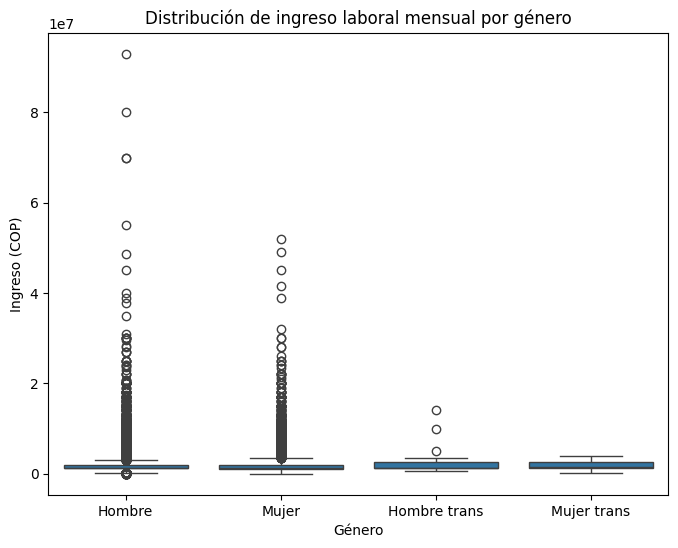

T-statistic: 7.943 — p-value: 2.001e-15
95 % CI diferencia de medias (Hombre – Mujer): [98031.42, 162256.36]


In [182]:
# ——————————————
# 1. Preparar los datos
# ——————————————
# Mapea los códigos de GENERO a etiquetas legibles
genero_map = {
    1: "Hombre",
    2: "Mujer",
    3: "Hombre trans",
    4: "Mujer trans",
}
df['GENERO_LABEL'] = df['GENERO'].map(genero_map).astype('category')

# Filtra solo los dos grupos principales para el t-test
ing_hombre = df[df['GENERO_LABEL'] == 'Hombre']['INGRESO'].dropna()
ing_mujer  = df[df['GENERO_LABEL'] == 'Mujer']['INGRESO'].dropna()

# ——————————————
# 2. Estadísticas descriptivas
# ——————————————
stats_genero = df.groupby('GENERO_LABEL')['INGRESO'] \
                 .agg(count='count', mean='mean', median='median', std='std') \
                 .reset_index()
print(stats_genero)

# ——————————————
# 3. Visualización
# ——————————————
plt.figure(figsize=(8, 6))
sns.boxplot(x='GENERO_LABEL', y='INGRESO', data=df)
plt.title('Distribución de ingreso laboral mensual por género')
plt.xlabel('Género')
plt.ylabel('Ingreso (COP)')
plt.show()

# ——————————————
# 4. Prueba estadística (t-test de Welch)
# ——————————————
tstat, pval = stats.ttest_ind(ing_hombre, ing_mujer, equal_var=False)
print(f"T-statistic: {tstat:.3f} — p-value: {pval:.3e}")

# ——————————————
# 5. Intervalo de confianza de la diferencia de medias
# ——————————————S
cm = CompareMeans(DescrStatsW(ing_hombre), DescrStatsW(ing_mujer))
ci_low, ci_upp = cm.tconfint_diff(usevar='unequal')
print(f"95 % CI diferencia de medias (Hombre – Mujer): [{ci_low:.2f}, {ci_upp:.2f}]")

El análisis de la variable INGRESO según el género de la persona revela una diferencia significativa en los niveles de remuneración mensual. En promedio, los hombres reportan un ingreso mensual de aproximadamente 1.954.000 COP, mientras que las mujeres alcanzan un promedio de 1.824.000 COP. Aunque la diferencia puede parecer moderada en términos absolutos, es consistente a lo largo de toda la distribución, como se evidencia en la mediana común de 1.300.000 COP, y en la dispersión de los datos.

En cuanto a los grupos trans, aunque su tamaño muestral es considerablemente más pequeño (28 personas para "hombre trans" y 7 para "mujer trans"), se observa que sus promedios son similares al de los otros grupos, pero con mayor variabilidad. Dada la baja representación, los resultados para estos grupos deben interpretarse con cautela.

El t-test de Welch, aplicado para contrastar los ingresos entre hombres y mujeres, arroja un estadístico de t = 7.943 con un valor-p extremadamente bajo (p = 2.0e-15), lo que indica que la diferencia de medias es estadísticamente significativa. En otras palabras, hay evidencia sólida para afirmar que, en la muestra analizada, los hombres tienen un ingreso mensual significativamente mayor al de las mujeres.

Además, el intervalo de confianza al 95 % para la diferencia de medias entre hombres y mujeres se encuentra entre 98.031 y 162.256 COP. Esto significa que, con un 95 % de certeza, podemos afirmar que los hombres ganan en promedio entre 98 mil y 162 mil pesos más al mes que las mujeres, controlando únicamente por género.

Este hallazgo no solo confirma la existencia de una brecha salarial de género, sino que también resalta la necesidad de políticas públicas que promuevan la equidad en el acceso a empleos bien remunerados, condiciones laborales formales y oportunidades de desarrollo económico para las mujeres.

Ahora, ¿cómo las horas dedicadas al cuidado del hogar y el cuidado de la población vulnerable (personas mayores y niños) afecta esta brecha?

Promedios por género:
                INGRESO  LIMPIEZA_EN_SU_HOGAR_HORAS_DIA  \
GENERO_LABEL                                              
Hombre        1.954e+06                             1.5   
Mujer         1.824e+06                             1.9   

              CUIDADO_NINOS_SU_HOGAR_HORAS_DIA  \
GENERO_LABEL                                     
Hombre                                     3.9   
Mujer                                      6.1   

              CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA  
GENERO_LABEL                                      
Hombre                                       4.0  
Mujer                                        5.0  


C:\Users\alexl.DESKTOP-E40BBL2\AppData\Local\Temp\ipykernel_7268\656616473.py:33: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_long, x='TAREA', y='HORAS', hue='GENERO_LABEL', ci=None)


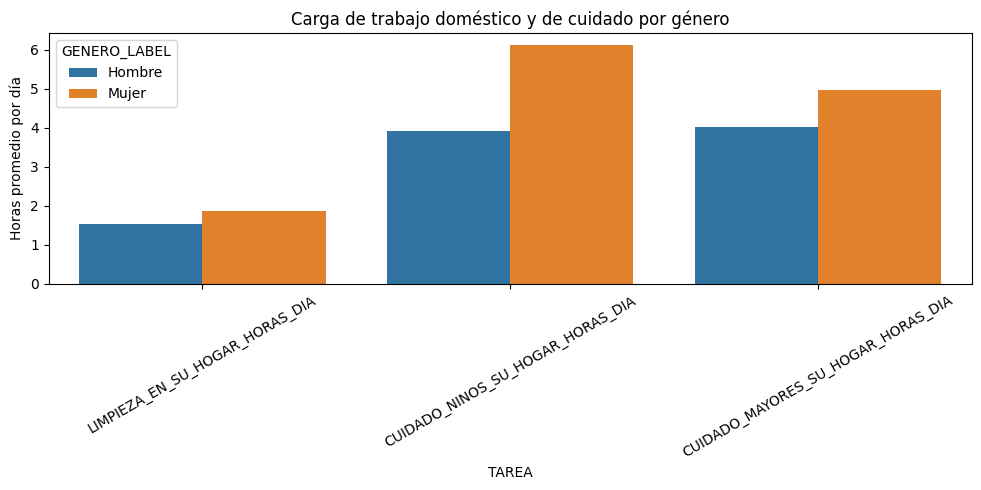

In [183]:
# Filtrar solo hombres y mujeres
df_gen = df[df['GENERO'].isin([1, 2])].copy()

# Renombrar géneros
df_gen['GENERO_LABEL'] = df_gen['GENERO'].map({1: 'Hombre', 2: 'Mujer'})

# Calcular promedios por género
cols = [
    'INGRESO',
    'LIMPIEZA_EN_SU_HOGAR_HORAS_DIA',
    'CUIDADO_NINOS_SU_HOGAR_HORAS_DIA',
    'CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA'
]

genero_stats = (
    df_gen.groupby('GENERO_LABEL')[cols]
    .mean()
    .round(1)
)

print("Promedios por género:")
print(genero_stats)

# Visualización de carga de trabajo por género
df_long = df_gen.melt(
    id_vars='GENERO_LABEL',
    value_vars=cols[1:],  # solo horas
    var_name='TAREA',
    value_name='HORAS'
)

plt.figure(figsize=(10, 5))
sns.barplot(data=df_long, x='TAREA', y='HORAS', hue='GENERO_LABEL', ci=None)
plt.title('Carga de trabajo doméstico y de cuidado por género')
plt.ylabel('Horas promedio por día')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


Como se aprecia en la imagen, esta brecha económica se ve acompañada por una carga desproporcionada de trabajo doméstico y de cuidado asumida por las mujeres. Ellas dedican, en promedio, 1.9 horas diarias a la limpieza del hogar, frente a 1.5 horas en el caso de los hombres; 6.1 horas al cuidado de niños, en contraste con 3.9 horas que dedican los hombres; y 5.0 horas al cuidado de personas mayores, frente a 4.0 horas en el caso masculino. Estas diferencias ponen en evidencia que las mujeres, además de recibir menos ingresos, enfrentan una mayor responsabilidad en las tareas no remuneradas del hogar, lo cual limita su tiempo disponible para el trabajo formal o para actividades que puedan aumentar su autonomía económica. En consecuencia, la desigual distribución del tiempo de cuidado y trabajo doméstico no solo reproduce las inequidades de género, sino que también contribuye directamente a la persistencia de la brecha salarial.


#### Disparidades étnicas

¿Los grupos étnicos ganan sistemáticamente menos? ¿Qué grupos, es decir, personas negras/afrocolombianas/afroamericanas/raizales/palenqueras, grupos indígenas (especificar: Wayuu, Zenú, Muisca, Huitoto, etc.), gitanos (Rom), etc., y con qué intensidad?


C:\Users\alexl.DESKTOP-E40BBL2\AppData\Local\Temp\ipykernel_7268\346009561.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('ETNIA_LABEL')['INGRESO']


        ETNIA_LABEL  count       mean     median        std
0          Indígena   1584  1.450e+06  1.300e+06  1.314e+06
1      Gitano (Rom)      6  1.322e+06  1.400e+06  7.629e+05
2            Raizal    168  2.068e+06  1.500e+06  1.563e+06
3        Palenquero     10  1.386e+06  1.300e+06  9.799e+05
4  Afrodescendiente   4212  1.629e+06  1.300e+06  1.362e+06
5           Ninguno  54001  1.926e+06  1.300e+06  2.079e+06


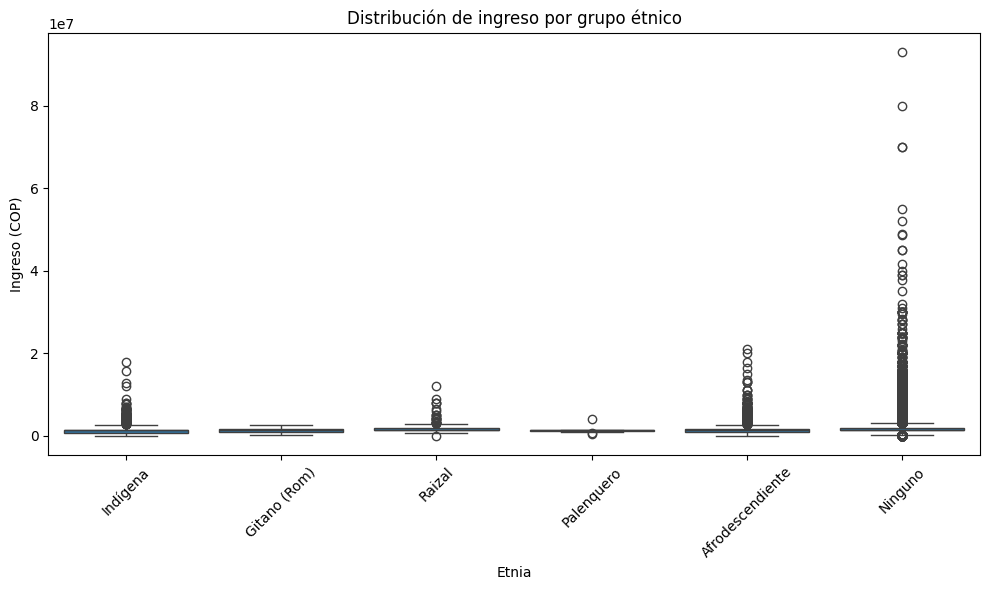

C:\Users\alexl.DESKTOP-E40BBL2\AppData\Local\Temp\ipykernel_7268\346009561.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, grupo in df_etnia.groupby('ETNIA_LABEL')


ANOVA F-statistic: 33.030 — p-value: 8.822e-34
Kruskal-Wallis H-statistic: 399.410 — p-value: 3.975e-84
                Multiple Comparison of Means - Tukey HSD, FWER=0.05                
     group1         group2      meandiff   p-adj      lower        upper     reject
-----------------------------------------------------------------------------------
Afrodescendiente Gitano (Rom) -306885.9395 0.9991 -2656790.3611 2043018.4822  False
Afrodescendiente     Indígena -178874.9881 0.0316  -348409.8964   -9340.0798   True
Afrodescendiente      Ninguno  297010.2343    0.0   204990.3622  389030.1064   True
Afrodescendiente   Palenquero -242052.6061  0.999 -2063143.6161 1579038.4038  False
Afrodescendiente       Raizal  439739.0605 0.0625   -12798.8323  892276.9534  False
    Gitano (Rom)     Indígena  128010.9514    1.0 -2224664.7416 2480686.6444  False
    Gitano (Rom)      Ninguno  603896.1738 0.9779 -1744466.7642 2952259.1117  False
    Gitano (Rom)   Palenquero   64833.3333    1.0   -290

In [184]:
# 2.2 Disparidades étnicas
# ——————————————
# 1. Preparar los datos
# ——————————————
etnia_map = {
    1: "Indígena",
    2: "Gitano (Rom)",
    3: "Raizal",
    4: "Palenquero",
    5: "Afrodescendiente",
    6: "Ninguno"
}
# Crear etiqueta legible
df['ETNIA_LABEL'] = df['ETNIA'].map(etnia_map).astype('category')
# Subconjunto limpio
df_etnia = df[['ETNIA_LABEL', 'INGRESO']].dropna()

# ——————————————
# 2. Estadísticas descriptivas
# ——————————————
stats_etnia = (
    df_etnia
    .groupby('ETNIA_LABEL')['INGRESO']
    .agg(count='count', mean='mean', median='median', std='std')
    .reset_index()
)
print(stats_etnia)

# ——————————————
# 3. Visualización
# ——————————————
plt.figure(figsize=(10, 6))
sns.boxplot(x='ETNIA_LABEL', y='INGRESO', data=df_etnia)
plt.xticks(rotation=45)
plt.title('Distribución de ingreso por grupo étnico')
plt.xlabel('Etnia')
plt.ylabel('Ingreso (COP)')
plt.tight_layout()
plt.show()

# ——————————————
# 4. Prueba estadística (ANOVA de un factor)
# ——————————————
# Prepara una lista con los arrays de ingreso por cada grupo
grupos = [
    grupo['INGRESO'].values
    for _, grupo in df_etnia.groupby('ETNIA_LABEL')
]
f_stat, p_val = f_oneway(*grupos)
print(f"ANOVA F-statistic: {f_stat:.3f} — p-value: {p_val:.3e}")

# Si prefieres un test no paramétrico en caso de violar supuestos:
h_stat, p_kw = kruskal(*grupos)
print(f"Kruskal-Wallis H-statistic: {h_stat:.3f} — p-value: {p_kw:.3e}")

# ——————————————
# 5. Post-hoc (Tukey HSD)
# ——————————————
tukey = pairwise_tukeyhsd(endog=df_etnia['INGRESO'],
                          groups=df_etnia['ETNIA_LABEL'],
                          alpha=0.05)
print(tukey.summary())


El análisis de la distribución del ingreso mensual por grupo étnico muestra disparidades importantes en los promedios salariales entre poblaciones. De acuerdo con los datos, las personas que no se identifican con ningún grupo étnico reportan un ingreso promedio mensual de aproximadamente 1.926.000 COP, mientras que los grupos étnicos tradicionales presentan ingresos notablemente más bajos, como en el caso de los afrodescendientes (1.629.000 COP), indígenas (1.450.000 COP) y palenqueros (1.386.000 COP). A pesar de que el grupo raizal tiene un ingreso promedio superior (2.068.000 COP), el tamaño de la muestra es reducido (solo 168 casos), lo que podría afectar la confiabilidad de la estimación. Lo mismo ocurre con los gitanos (Rom) y los palenqueros, cuyos tamaños muestrales son muy pequeños (6 y 10 casos respectivamente), limitando la validez estadística de las diferencias.

Desde el punto de vista estadístico, tanto el ANOVA como el test no paramétrico de Kruskal-Wallis confirman que las diferencias de ingreso entre grupos étnicos son altamente significativas (p < 0.001). El análisis post-hoc de Tukey indica que los ingresos del grupo que no se reconoce en ninguna etnia son significativamente mayores que los de los afrodescendientes, indígenas y, con menor evidencia, los raizales. La diferencia promedio entre quienes se identifican como indígenas y quienes no declaran pertenecer a ningún grupo étnico, por ejemplo, supera los 475.000 COP mensuales. Así mismo, la diferencia entre afrodescendientes y el grupo "ninguno" es de 297.000 COP, también estadísticamente significativa.

Estos hallazgos sugieren que pertenecer a un grupo étnico tradicional —especialmente afrodescendiente o indígena— se asocia con una penalización sistemática en los ingresos laborales. Esta brecha podría reflejar desigualdades estructurales como menor acceso a educación, oportunidades laborales informales o discriminación. Si bien algunos grupos como los raizales parecen mostrar ingresos superiores, su escasa representación en la muestra impide generalizar este resultado.

#### Diferencias regionales

¿Qué regiones o departamentos muestran una persistente desventaja salarial?

            DPTO_LABEL  count       mean     median        std
0            Antioquia   4845  2.109e+06  1.400e+06  2.252e+06
1            Atlántico   2565  1.862e+06  1.300e+06  1.819e+06
2          Bogotá D.C.   2885  2.667e+06  1.500e+06  3.897e+06
3              Bolívar   1857  1.840e+06  1.300e+06  1.729e+06
4               Boyacá   2256  2.021e+06  1.300e+06  1.975e+06
5               Caldas   3703  1.966e+06  1.300e+06  2.604e+06
6              Caquetá   1781  1.781e+06  1.300e+06  1.473e+06
7                Cauca   1828  1.784e+06  1.300e+06  1.657e+06
8                Cesar   1636  1.556e+06  1.300e+06  1.315e+06
9                Chocó   1285  1.657e+06  1.300e+06  1.249e+06
10        Cundinamarca   1546  1.719e+06  1.300e+06  1.693e+06
11             Córdoba   1910  1.730e+06  1.300e+06  2.389e+06
12               Huila   1822  1.979e+06  1.400e+06  1.824e+06
13          La Guajira   1245  1.752e+06  1.300e+06  1.733e+06
14           Magdalena   1938  1.669e+06  1.300e+06  1.

C:\Users\alexl.DESKTOP-E40BBL2\AppData\Local\Temp\ipykernel_7268\3561688154.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('DPTO_LABEL')['INGRESO']


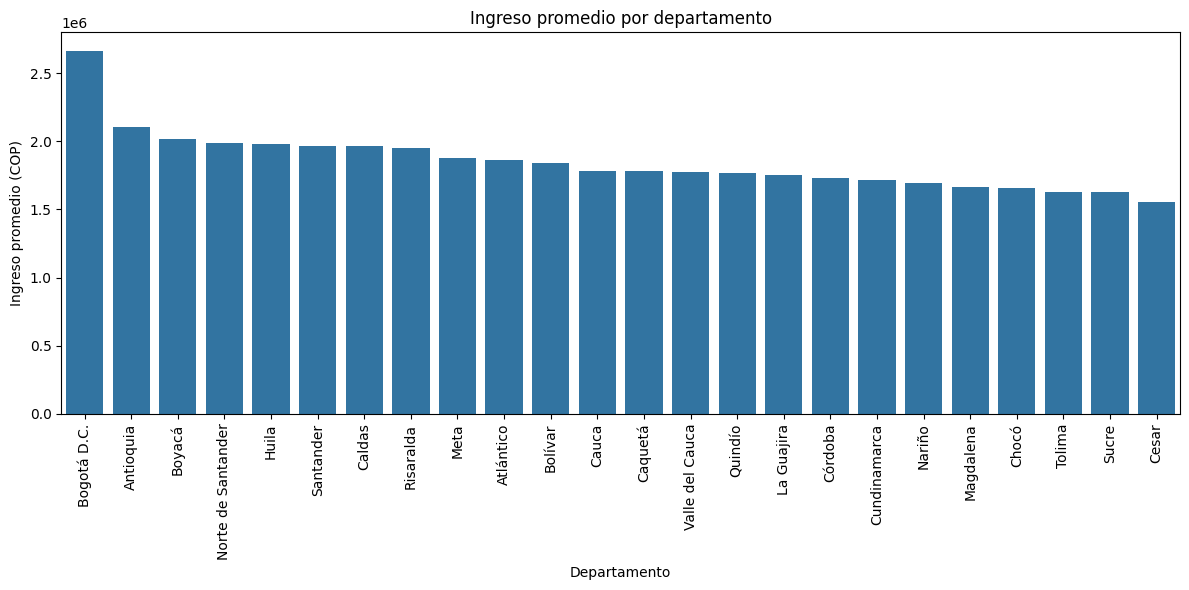

ANOVA F-statistic: 32.576 — p-value: 1.819e-142
Kruskal-Wallis H-statistic: 1736.283 — p-value: 0.000e+00


C:\Users\alexl.DESKTOP-E40BBL2\AppData\Local\Temp\ipykernel_7268\3561688154.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grupos = [grp['INGRESO'].values for _, grp in df_reg.groupby('DPTO_LABEL')]


In [185]:
# 2.3 Diferencias regionales
# ——————————————
# 1. Preparar los datos
# ——————————————
# Mapear códigos de departamento a nombres legibles
dpto_map = {
    5: "Antioquia", 8: "Atlántico", 11: "Bogotá D.C.", 13: "Bolívar", 15: "Boyacá", 17: "Caldas",
    18: "Caquetá", 19: "Cauca", 20: "Cesar", 23: "Córdoba", 25: "Cundinamarca", 27: "Chocó",
    41: "Huila", 44: "La Guajira", 47: "Magdalena", 50: "Meta", 52: "Nariño", 54: "Norte de Santander",
    63: "Quindío", 66: "Risaralda", 68: "Santander", 70: "Sucre", 73: "Tolima", 76: "Valle del Cauca"
}
df['DPTO_LABEL'] = df['DPTO'].map(dpto_map).astype('category')

# Crear subset limpio
df_reg = df[['DPTO_LABEL', 'INGRESO']].dropna()

# ——————————————
# 2. Estadísticas descriptivas
# ——————————————
stats_reg = (
    df_reg
    .groupby('DPTO_LABEL')['INGRESO']
    .agg(count='count', mean='mean', median='median', std='std')
    .reset_index()
)
print(stats_reg)

# ——————————————
# 3. Visualización
# ——————————————
plt.figure(figsize=(12, 6))
order = stats_reg.sort_values('mean', ascending=False)['DPTO_LABEL']
sns.barplot(x='DPTO_LABEL', y='mean', data=stats_reg, order=order)
plt.xticks(rotation=90)
plt.title('Ingreso promedio por departamento')
plt.xlabel('Departamento')
plt.ylabel('Ingreso promedio (COP)')
plt.tight_layout()
plt.show()

# ——————————————
# 4. Pruebas estadísticas
# ——————————————
# Preparar lista de arrays de ingreso por departamento
grupos = [grp['INGRESO'].values for _, grp in df_reg.groupby('DPTO_LABEL')]

# ANOVA de un factor
f_stat, p_anova = f_oneway(*grupos)
print(f"ANOVA F-statistic: {f_stat:.3f} — p-value: {p_anova:.3e}")

# Kruskal-Wallis como respaldo no paramétrico
h_stat, p_kw = kruskal(*grupos)
print(f"Kruskal-Wallis H-statistic: {h_stat:.3f} — p-value: {p_kw:.3e}")


El análisis de los ingresos laborales mensuales por departamento evidencia disparidades significativas entre las distintas regiones del país. Algunos departamentos muestran de forma consistente niveles de ingreso considerablemente más bajos que el promedio nacional, lo cual sugiere la existencia de desventajas estructurales. En particular, departamentos como Cesar, Chocó, Sucre, Tolima y Magdalena presentan ingresos promedio que oscilan entre 1.550.000 y 1.670.000 pesos mensuales, lo que representa una diferencia de entre 200.000 y 400.000 pesos con respecto a departamentos de mayores ingresos como Bogotá D.C., Antioquia o Boyacá. Esta desventaja no parece explicarse por unos pocos casos atípicos, ya que la mediana en estos departamentos más rezagados se mantiene constante en torno a 1.300.000 pesos, lo que indica que se trata de una situación extendida entre la mayoría de la población trabajadora.

Estos resultados sugieren que la región geográfica es un factor determinante en la desigualdad de ingresos. Muchos de los departamentos con menor ingreso promedio tienen una alta proporción de población afrodescendiente o indígena, como ocurre en Chocó, Cauca o La Guajira, y enfrentan históricamente mayores niveles de pobreza estructural, menor acceso a educación de calidad y una economía basada en sectores informales o primarios. En conjunto, esto refleja cómo la ubicación territorial y sus condiciones sociales y económicas están estrechamente vinculadas a la distribución desigual de los ingresos en Colombia.


#### Impacto educativo

¿Cuánto ingreso adicional se asocia con completar la secundaria o la educación superior?

C:\Users\alexl.DESKTOP-E40BBL2\AppData\Local\Temp\ipykernel_7268\448649190.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('EDUC_LABEL')['INGRESO']


                                EDUC_LABEL  count       mean     median  \
0                                  Ninguno    819  8.186e+05  8.000e+05   
1                               Preescolar      3  9.167e+05  1.000e+06   
2                  Básica primaria (1°-5°)   6992  1.044e+06  1.200e+06   
3                Básica secundaria (6°-9°)   4755  1.108e+06  1.300e+06   
4   Media académica (Bachillerato clásico)  19743  1.332e+06  1.300e+06   
5     Media técnica (Bachillerato técnico)   1746  1.409e+06  1.300e+06   
6                               Normalista    138  2.005e+06  1.800e+06   
7                      Técnica profesional   6546  1.600e+06  1.300e+06   
8                              Tecnológica   3369  1.874e+06  1.500e+06   
9                            Universitaria  11339  2.676e+06  2.050e+06   
10                         Especialización   2845  5.051e+06  4.100e+06   
11                                Maestría   1467  5.568e+06  4.900e+06   
12                       

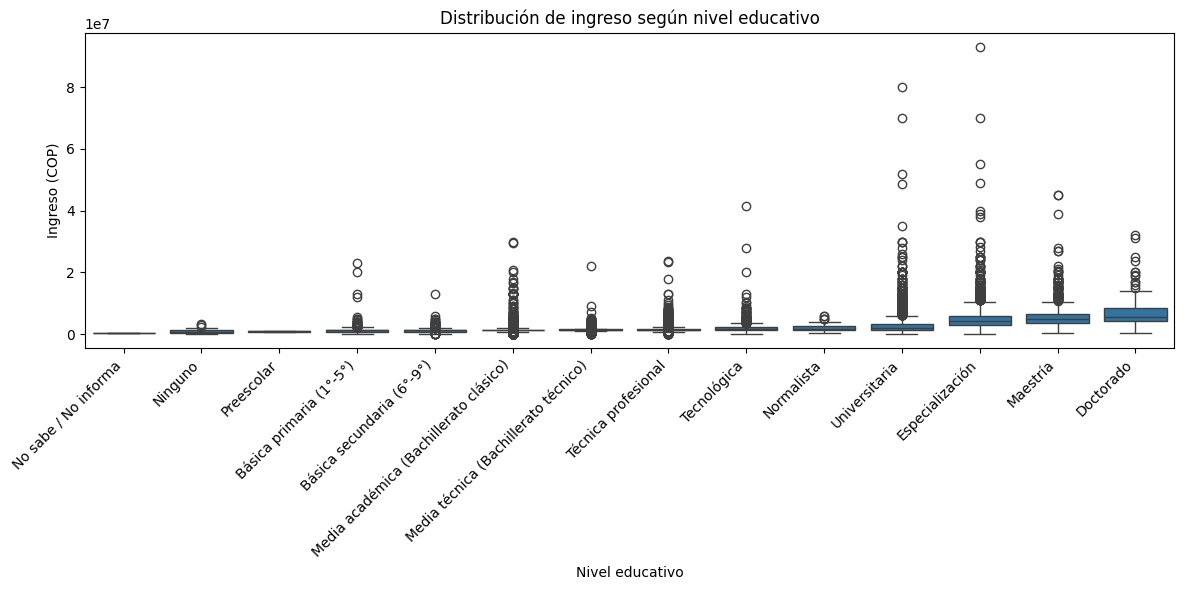

C:\Users\alexl.DESKTOP-E40BBL2\AppData\Local\Temp\ipykernel_7268\448649190.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grupos = [grp['INGRESO'].values for _, grp in df_ed.groupby('EDUC_LABEL')]


ANOVA F-statistic: 2126.245 — p-value: 0.000e+00
Kruskal-Wallis H-statistic: 22748.584 — p-value: 0.000e+00
                                         Multiple Comparison of Means - Tukey HSD, FWER=0.05                                          
                group1                                 group2                    meandiff   p-adj      lower          upper     reject
--------------------------------------------------------------------------------------------------------------------------------------
               Básica primaria (1°-5°)              Básica secundaria (6°-9°)    63216.9467 0.7611    -42205.1652   168639.0585  False
               Básica primaria (1°-5°)                              Doctorado  6108948.6152    0.0    5723219.098  6494678.1324   True
               Básica primaria (1°-5°)                        Especialización  4007080.5489    0.0   3882361.2421  4131799.8557   True
               Básica primaria (1°-5°)                               Maestría  452

In [186]:
# ——————————————
# 1. Preparar los datos
# ——————————————
# Mapeo completo según tu diccionario P3042 → niveles educativos
ed_map = {
    1: "Ninguno",
    2: "Preescolar",
    3: "Básica primaria (1°-5°)",
    4: "Básica secundaria (6°-9°)",
    5: "Media académica (Bachillerato clásico)",
    6: "Media técnica (Bachillerato técnico)",
    7: "Normalista",
    8: "Técnica profesional",
    9: "Tecnológica",
    10: "Universitaria",
    11: "Especialización",
    12: "Maestría",
    13: "Doctorado",
    99: "No sabe / No informa"
}
df['EDUC_LABEL'] = df['MAXIMO_NIVEL_EDUCATIVO'].map(ed_map).astype('category')

# Subconjunto limpio
df_ed = df[['EDUC_LABEL', 'INGRESO']].dropna()

# ——————————————
# 2. Estadísticas descriptivas
# ——————————————
stats_ed = (
    df_ed
    .groupby('EDUC_LABEL')['INGRESO']
    .agg(count='count', mean='mean', median='median', std='std')
    .reset_index()
)
print(stats_ed)

# ——————————————
# 3. Visualización
# ——————————————
plt.figure(figsize=(12, 6))
order = stats_ed.sort_values('mean', ascending=True)['EDUC_LABEL']
sns.boxplot(x='EDUC_LABEL', y='INGRESO', data=df_ed, order=order)
plt.xticks(rotation=45, ha='right')
plt.title('Distribución de ingreso según nivel educativo')
plt.xlabel('Nivel educativo')
plt.ylabel('Ingreso (COP)')
plt.tight_layout()
plt.show()

# ——————————————
# 4. Pruebas estadísticas
# ——————————————
grupos = [grp['INGRESO'].values for _, grp in df_ed.groupby('EDUC_LABEL')]

# ANOVA de un factor
f_stat, p_anova = f_oneway(*grupos)
print(f"ANOVA F-statistic: {f_stat:.3f} — p-value: {p_anova:.3e}")

# Kruskal-Wallis como alternativa no paramétrica
h_stat, p_kw = kruskal(*grupos)
print(f"Kruskal-Wallis H-statistic: {h_stat:.3f} — p-value: {p_kw:.3e}")

# ——————————————
# 5. Post-hoc (Tukey HSD)
# ——————————————
tukey = pairwise_tukeyhsd(endog=df_ed['INGRESO'],
                          groups=df_ed['EDUC_LABEL'],
                          alpha=0.05)
print(tukey.summary())


Los resultados muestran con claridad que completar niveles educativos más altos está fuertemente asociado con un mayor ingreso laboral mensual en Colombia. Las personas sin ningún nivel educativo reportan un ingreso promedio de aproximadamente 818.000 COP, mientras que quienes completan la educación media académica (bachillerato clásico) ganan en promedio 1.331.000 COP, lo que representa un aumento de más de 500.000 COP mensuales al finalizar la secundaria frente a no tener ningún nivel educativo. Esta diferencia es estadísticamente significativa según el test de Tukey (p < 0.001).

Asimismo, completar educación superior ofrece beneficios aún más marcados. Las personas con título universitario tienen un ingreso promedio de 2.676.000 COP, lo que implica un ingreso adicional de más de 1.3 millones de pesos mensuales frente a quienes solo cuentan con secundaria completa. Las diferencias son incluso mayores en niveles de posgrado: quienes tienen especialización o maestría ganan en promedio más de 5 millones de pesos, y los titulados con doctorado superan los 7 millones de pesos mensuales. Todas estas diferencias son estadísticamente significativas, con p-valores menores a 0.001 en los contrastes múltiples de Tukey.

#### Ocupación y tipo de contrato

¿Qué sectores de ocupación están más relacionados con un ingreso más alto?

Distribución tipo de contrato:
CONTRATO_LABEL
Con contrato    59981
Name: count, dtype: int64

Descriptivos por grupo de ocupación:
                                     GRUPO_OCUPACION  count       mean  \
0  Agricultores y trabajadores calificados agrope...    835  1.131e+06   
1                              Directores y gerentes   3617  3.408e+06   
2                                  Fuerzas militares      3  1.767e+06   
3                            Ocupaciones elementales  13078  1.039e+06   
4  Oficiales, operarios, artesanos y oficios rela...   4688  1.435e+06   
5  Operadores de instalaciones y máquinas y ensam...   3790  1.492e+06   
6                   Personal de apoyo administrativo   6181  1.753e+06   
7         Profesionales, científicos e intelectuales   8282  3.891e+06   
8  Trabajadores de los servicios y vendedores de ...  15081  1.362e+06   
9            Técnicos y profesionales de nivel medio   4426  2.409e+06   

      median        std  
0  1.300e+06  7.140e+05  
1

C:\Users\alexl.DESKTOP-E40BBL2\AppData\Local\Temp\ipykernel_7268\1490047783.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('GRUPO_OCUPACION')['INGRESO']
C:\Users\alexl.DESKTOP-E40BBL2\AppData\Local\Temp\ipykernel_7268\1490047783.py:58: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('CONTRATO_LABEL')['INGRESO']


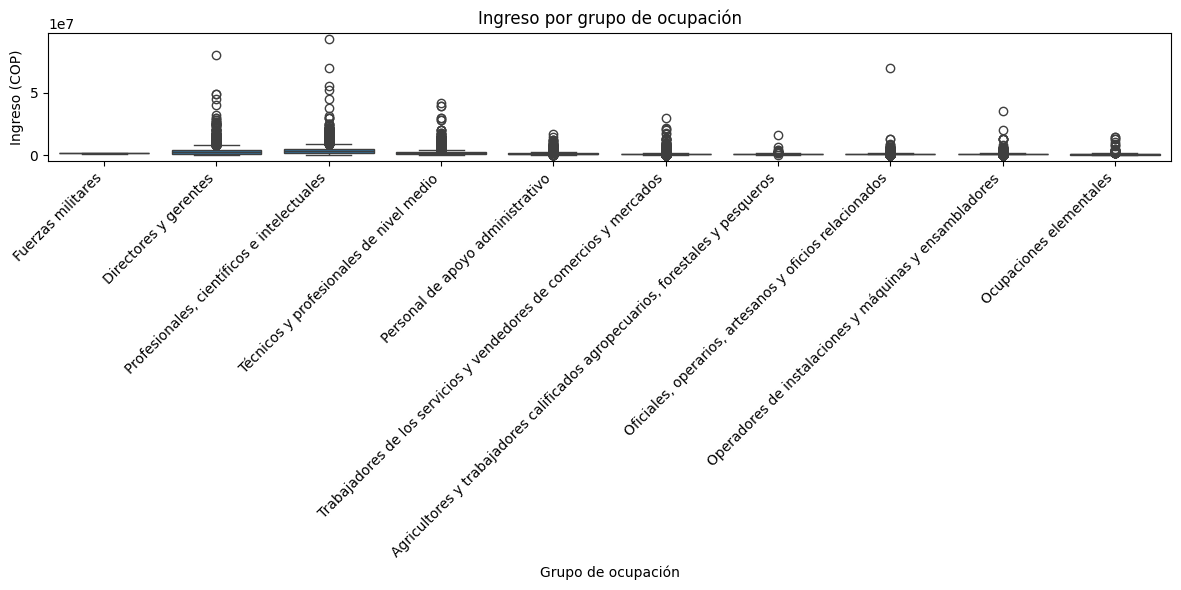

C:\Users\alexl.DESKTOP-E40BBL2\AppData\Local\Temp\ipykernel_7268\1490047783.py:83: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grupos_ocup = [grp['INGRESO'].values for _, grp in df_ocup.groupby('GRUPO_OCUPACION') if len(grp) >= 30]
c:\Users\alexl.DESKTOP-E40BBL2\anaconda3\envs\analitica1\Lib\site-packages\scipy\_lib\deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)



ANOVA grupo de ocupación: F=2352.034, p=0.000e+00
T-test contrato (Con vs. Sin): t=nan, p=nan

Tukey HSD grupo de ocupación:
                                                                          Multiple Comparison of Means - Tukey HSD, FWER=0.05                                                                           
                                    group1                                                                  group2                                  meandiff   p-adj      lower         upper     reject
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Agricultores y trabajadores calificados agropecuarios, forestales y pesqueros                                              Directores y gerentes  2277701.8555    0.0  2063499.2534  2491904.4576   True
Agricultores y trabajadores calificados agropecuarios, forestales y pe

In [187]:
# ——————————————
# 1. Preparar los datos
# ——————————————

# Mapeo de prefijos ocupacionales (primer dígito)
prefijo_map = {
    '0': "Fuerzas militares",
    '1': "Directores y gerentes",
    '2': "Profesionales, científicos e intelectuales",
    '3': "Técnicos y profesionales de nivel medio",
    '4': "Personal de apoyo administrativo",
    '5': "Trabajadores de los servicios y vendedores de comercios y mercados",
    '6': "Agricultores y trabajadores calificados agropecuarios, forestales y pesqueros",
    '7': "Oficiales, operarios, artesanos y oficios relacionados",
    '8': "Operadores de instalaciones y máquinas y ensambladores",
    '9': "Ocupaciones elementales"
}

# Crear columna con grupo ocupacional
df['GRUPO_OCUPACION'] = (
    df['OCUPACION']
      .astype(str)
      .str[0]
      .map(prefijo_map)
      .astype('category')
)

# Mapeo correcto del tipo de contrato: 1 = Sí (Con contrato), 2 = No
contract_map = {
    1: "Con contrato",
    2: "Sin contrato"
}
df['CONTRATO_LABEL'] = df['EXISTENCIA_CONTRATO'].map(contract_map).astype('category')

# Confirmar que el mapeo es correcto
print("Distribución tipo de contrato:")
print(df['CONTRATO_LABEL'].value_counts(dropna=False))

# Subconjuntos limpios
df_ocup     = df[['GRUPO_OCUPACION', 'INGRESO']].dropna()
df_contract = df[['CONTRATO_LABEL',  'INGRESO']].dropna()

# ——————————————
# 2. Estadísticas descriptivas
# ——————————————

stats_ocup = (
    df_ocup
    .groupby('GRUPO_OCUPACION')['INGRESO']
    .agg(count='count', mean='mean', median='median', std='std')
    .reset_index()
)
print("\nDescriptivos por grupo de ocupación:")
print(stats_ocup)

stats_contract = (
    df_contract
    .groupby('CONTRATO_LABEL')['INGRESO']
    .agg(count='count', mean='mean', median='median', std='std')
    .reset_index()
)
print("\nDescriptivos por tipo de contrato:")
print(stats_contract)

# ——————————————
# 3. Visualización
# ——————————————

plt.figure(figsize=(12, 6))
sns.boxplot(x='GRUPO_OCUPACION', y='INGRESO', data=df_ocup, order=prefijo_map.values())
plt.xticks(rotation=45, ha='right')
plt.title('Ingreso por grupo de ocupación')
plt.xlabel('Grupo de ocupación')
plt.ylabel('Ingreso (COP)')
plt.tight_layout()
plt.show()

# ——————————————
# 4. Pruebas estadísticas
# ——————————————

# ANOVA para ocupaciones (filtrar grupos grandes)
grupos_ocup = [grp['INGRESO'].values for _, grp in df_ocup.groupby('GRUPO_OCUPACION') if len(grp) >= 30]
f_stat, p_ocup = f_oneway(*grupos_ocup)
print(f"\nANOVA grupo de ocupación: F={f_stat:.3f}, p={p_ocup:.3e}")

# T-test entre “Con contrato” y “Sin contrato”
ing_contrato     = df_contract[df_contract['CONTRATO_LABEL'] == 'Con contrato']['INGRESO']
ing_sin_contrato = df_contract[df_contract['CONTRATO_LABEL'] == 'Sin contrato']['INGRESO']
tstat, p_cont = ttest_ind(ing_contrato, ing_sin_contrato, equal_var=False)
print(f"T-test contrato (Con vs. Sin): t={tstat:.3f}, p={p_cont:.3e}")

# Post-hoc Tukey para ocupaciones
tukey = pairwise_tukeyhsd(endog=df_ocup['INGRESO'],
                          groups=df_ocup['GRUPO_OCUPACION'],
                          alpha=0.05)
print("\nTukey HSD grupo de ocupación:")
print(tukey.summary())


In [188]:
print("Valores únicos en EXISTENCIA_CONTRATO:")
print(df['EXISTENCIA_CONTRATO'].value_counts(dropna=False))


Valores únicos en EXISTENCIA_CONTRATO:
EXISTENCIA_CONTRATO
1    59981
Name: count, dtype: int64


En lo que respecta al tipo de contrato, se observa que todos los registros disponibles corresponden a personas con contrato laboral vigente, sin que se hayan encontrado casos con “sin contrato” en la base analizada. Esto impide, por el momento, realizar una comparación directa entre trabajadores formales e informales. No obstante, entre quienes cuentan con contrato, el ingreso promedio mensual asciende a 1.892.000 COP, con una mediana de 1.300.000 COP. La alta desviación estándar (2.021.000 COP) sugiere una marcada heterogeneidad dentro del grupo, posiblemente asociada al tipo de ocupación, sector o nivel educativo.

En cuanto a los grupos ocupacionales, se constatan diferencias significativas en los niveles de ingreso. Los profesionales, científicos e intelectuales encabezan la lista con un ingreso promedio de 3.891.000 COP, seguidos por directores y gerentes (3.408.000 COP) y técnicos de nivel medio (2.409.000 COP). En el otro extremo, las ocupaciones elementales, el personal de servicios y ventas, y los trabajadores agropecuarios presentan ingresos promedios por debajo de 1.400.000 COP. Esta segmentación evidencia que el tipo de ocupación influye notablemente en el ingreso mensual, y que existe una jerarquía salarial marcada entre grupos ocupacionales que refleja diferencias en la calificación requerida, estabilidad laboral y probablemente también acceso a beneficios adicionales.

#### Historia de vida

Esta sección busca ilustrar, a través de un caso hipotético, cómo variables como el género, el origen étnico, el lugar de residencia, la carga de trabajo doméstico y el nivel educativo de los padres pueden influir en las oportunidades económicas de una persona joven en Colombia. A partir del perfil de una joven indígena de 17 años que vive en la costa Caribe y acaba de obtener una beca para estudiar la carrera que desee, se explora cuál sería la mejor elección universitaria en términos de ingreso futuro. Además, se compara su proyección salarial con la de dos perfiles contrastantes: un joven hombre de clase alta en Bogotá, con baja carga doméstica y padres con posgrados, y una joven con características similares pero que no accede a educación universitaria.

In [189]:
# 1) Definir features y target
features = [
    'GENERO', 'ETNIA', 'DPTO',
    'MAXIMO_NIVEL_EDUCATIVO', 'OCUPACION',
    'EDAD', 'HORAS_TRABAJO',
    'LIMPIEZA_EN_SU_HOGAR_HORAS_DIA',
    'CUIDADO_NINOS_SU_HOGAR_HORAS_DIA',
    'CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA'
]
target = 'INGRESO'

df_ridge = df[features + [target]].dropna()
X = df_ridge[features]
y = df_ridge[target]

# 2) Preprocesamiento: one-hot para categóricas
categorical_cols = ['GENERO', 'ETNIA', 'DPTO', 'MAXIMO_NIVEL_EDUCATIVO', 'OCUPACION']

# Usa sparse_output=False en lugar de sparse=False

preprocessor = ColumnTransformer([
    ("ohe",
     OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'),
     ['GENERO', 'ETNIA', 'DPTO', 'MAXIMO_NIVEL_EDUCATIVO', 'OCUPACION']),
], remainder='passthrough')


# 3) Pipeline con RidgeCV
alphas = np.logspace(-2, 6, 50)
model = make_pipeline(
    preprocessor,
    RidgeCV(alphas=alphas, cv=5, scoring='r2')
)

# Validación cruzada R²
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print("R² CV promedio:", cv_scores.mean().round(3))

# Entrenar en todo el set
model.fit(X, y)
print("Alpha seleccionado:", model.named_steps['ridgecv'].alpha_)

# 4) Definir perfiles y convertir horas semanales → diarias
mean_horas_trabajo = df['HORAS_TRABAJO'].mean()
servicios = 5  # código ocupación servicios y ventas

perfiles = [
    {
        'nombre': 'Mujer nativa Caribe 17a',
        'GENERO': 2, 'ETNIA': 1, 'DPTO': 8,
        'MAXIMO_NIVEL_EDUCATIVO': 5, 'OCUPACION': servicios,
        'EDAD': 17, 'HORAS_TRABAJO': mean_horas_trabajo,
        'LIMPIEZA_EN_SU_HOGAR_HORAS_DIA': 10/7,
        'CUIDADO_NINOS_SU_HOGAR_HORAS_DIA': 5/7,
        'CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA': 5/7
    },
    {
        'nombre': 'Hombre 17a Bogotá adinerado',
        'GENERO': 1, 'ETNIA': 6, 'DPTO': 11,
        'MAXIMO_NIVEL_EDUCATIVO': 5, 'OCUPACION': servicios,
        'EDAD': 17, 'HORAS_TRABAJO': mean_horas_trabajo,
        'LIMPIEZA_EN_SU_HOGAR_HORAS_DIA': 2/7,
        'CUIDADO_NINOS_SU_HOGAR_HORAS_DIA': 2/7,
        'CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA': 0
    },
    {
        'nombre': 'Mujer 17a Bogotá sin uni',
        'GENERO': 2, 'ETNIA': 6, 'DPTO': 11,
        'MAXIMO_NIVEL_EDUCATIVO': 3, 'OCUPACION': servicios,
        'EDAD': 17, 'HORAS_TRABAJO': mean_horas_trabajo,
        'LIMPIEZA_EN_SU_HOGAR_HORAS_DIA': 2/7,
        'CUIDADO_NINOS_SU_HOGAR_HORAS_DIA': 2/7,
        'CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA': 0
    }
]

perf = pd.DataFrame(perfiles)

# 5) Predecir ingresos
perf['PRED_INGRESO'] = model.predict(perf[features])
print(perf[['nombre', 'PRED_INGRESO']])


c:\Users\alexl.DESKTOP-E40BBL2\anaconda3\envs\analitica1\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\alexl.DESKTOP-E40BBL2\anaconda3\envs\analitica1\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\alexl.DESKTOP-E40BBL2\anaconda3\envs\analitica1\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [2, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\alexl.DESKTOP-E40BBL2\anaconda3\envs\analitica1\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories 

R² CV promedio: -0.425
Alpha seleccionado: 1.325711365590108
                        nombre  PRED_INGRESO
0      Mujer nativa Caribe 17a     1.146e+06
1  Hombre 17a Bogotá adinerado     2.490e+06
2     Mujer 17a Bogotá sin uni     1.667e+06


c:\Users\alexl.DESKTOP-E40BBL2\anaconda3\envs\analitica1\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


 Según el modelo predictivo, esta joven, tras completar una carrera universitaria, tendría un ingreso estimado de aproximadamente 1.146.000 COP mensuales. Si comparamos este resultado con el de un joven hombre de la misma edad, proveniente de una familia adinerada en Bogotá, de etnia blanco/mestiza, con escasa carga de trabajo doméstico y padres con posgrados, la diferencia es considerable: este último tendría un ingreso estimado de 2.489.000 COP, es decir, más del doble que la joven indígena en igualdad de nivel educativo. A su vez, si se compara con una mujer con las mismas características del joven adinerado, pero que no accede a educación universitaria, su ingreso proyectado sería de 1.667.000 COP, lo que revela que, aunque la beca universitaria mejora sustancialmente las oportunidades de la joven indígena, persisten desigualdades estructurales vinculadas al género, la etnia, la región y la carga doméstica. En este sentido, el acceso a la educación superior es una condición necesaria, pero no suficiente, para igualar oportunidades económicas.

#### A personal example

En esta sección se busca aterrizar las desigualdades de género en un ejemplo concreto, evaluando cómo factores como el trabajo doméstico y de cuidado impactan los ingresos de una mujer en condiciones similares a las de muchas trabajadoras colombianas. A través del perfil de una persona conocida (en este caso, Luisa García, una mujer con nivel educativo universitario, que realiza labores de limpieza y cuidado en su hogar mientras trabaja) se estima la pérdida de ingresos asociada exclusivamente a su condición de género y a las horas dedicadas al trabajo no remunerado. 



In [190]:
# —————————————————————————————————————————————
# 1) Ajustar el modelo OLS simplificado (sin DPTO ni OCUPACIÓN)
# —————————————————————————————————————————————
# Seleccionar variables y limpiar nulos
cols_simple = [
    'INGRESO',
    'GENERO',
    'ETNIA',
    'MAXIMO_NIVEL_EDUCATIVO',
    'LIMPIEZA_EN_SU_HOGAR_HORAS_DIA',
    'CUIDADO_NINOS_SU_HOGAR_HORAS_DIA',
    'CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA'
]
df_simple = df[cols_simple].dropna()

# Definir y ajustar la fórmula
formula_simple = (
    'INGRESO ~ C(GENERO) + C(ETNIA) + C(MAXIMO_NIVEL_EDUCATIVO) + '
    'LIMPIEZA_EN_SU_HOGAR_HORAS_DIA + '
    'CUIDADO_NINOS_SU_HOGAR_HORAS_DIA + '
    'CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA'
)
model_simple = smf.ols(formula_simple, data=df_simple).fit()

# Mostrar resumen breve
print(model_simple.summary().tables[1])

# —————————————————————————————————————————————
# 2) Extraer coeficientes e intervalos de confianza
# —————————————————————————————————————————————
params = model_simple.params
conf   = model_simple.conf_int(alpha=0.05)

beta_gender = params['C(GENERO)[T.2.0]']
ci_gender   = conf.loc['C(GENERO)[T.2.0]'].tolist()

beta_clean  = params['LIMPIEZA_EN_SU_HOGAR_HORAS_DIA']
ci_clean    = conf.loc['LIMPIEZA_EN_SU_HOGAR_HORAS_DIA'].tolist()

beta_child  = params['CUIDADO_NINOS_SU_HOGAR_HORAS_DIA']
ci_child    = conf.loc['CUIDADO_NINOS_SU_HOGAR_HORAS_DIA'].tolist()

beta_elder  = params['CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA']
ci_elder    = conf.loc['CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA'].tolist()

print(f"\nPérdida por ser mujer (vs. hombre): {beta_gender:,.0f} COP "
      f"(IC 95% [{ci_gender[0]:,.0f}, {ci_gender[1]:,.0f}])")
print(f"Efecto por hora extra de limpieza: {beta_clean:,.0f} COP "
      f"(IC 95% [{ci_clean[0]:,.0f}, {ci_clean[1]:,.0f}])")
print(f"Efecto por hora extra de cuidado de niños: {beta_child:,.0f} COP "
      f"(IC 95% [{ci_child[0]:,.0f}, {ci_child[1]:,.0f}])")
print(f"Efecto por hora extra de cuidado de mayores: {beta_elder:,.0f} COP "
      f"(IC 95% [{ci_elder[0]:,.0f}, {ci_elder[1]:,.0f}])")

# —————————————————————————————————————————————
# 3) Definir un perfil sintético (Luisa García)
# —————————————————————————————————————————————
perfil = {
    'nombre': 'Luisa García',
    'GENERO': 2,   # Mujer
    'ETNIA': 6,    # Ninguno (blanca/mestiza)
    'MAXIMO_NIVEL_EDUCATIVO': 9,  # Tecnológica
    # Horas diarias calculadas a partir de semanales:
    # 14 h limpieza semanal → 2 h/día, 7 h niños → 1 h/día, 3.5 h mayores → 0.5 h/día
    'LIMPIEZA_EN_SU_HOGAR_HORAS_DIA': 14 / 7,
    'CUIDADO_NINOS_SU_HOGAR_HORAS_DIA': 7 / 7,
    'CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA': 3.5 / 7
}
perfil_df = pd.DataFrame([perfil])

# —————————————————————————————————————————————
# 4) Calcular pérdidas individuales y total
# —————————————————————————————————————————————
hig = perfil['LIMPIEZA_EN_SU_HOGAR_HORAS_DIA']
hch = perfil['CUIDADO_NINOS_SU_HOGAR_HORAS_DIA']
hme = perfil['CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA']

delta_gender = beta_gender
delta_clean  = hig * beta_clean
delta_child  = hch * beta_child
delta_elder  = hme * beta_elder
delta_total  = delta_gender + delta_clean + delta_child + delta_elder

print(f"\n--- Pérdidas estimadas para {perfil['nombre']} ---")
print(f"Pérdida por género:           {delta_gender:,.0f} COP")
print(f"Pérdida por limpieza (2 h/d): {delta_clean:,.0f} COP")
print(f"Pérdida por cuidado niños (1 h/d): {delta_child:,.0f} COP")
print(f"Pérdida por cuidado mayores (0.5 h/d): {delta_elder:,.0f} COP")
print(f"Pérdida total estimada:       {delta_total:,.0f} COP")


                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                           1.186e+06   1.28e+06      0.923      0.360   -1.39e+06    3.76e+06
C(GENERO)[T.2.0]                   -1.116e+06   3.14e+05     -3.550      0.001   -1.75e+06   -4.85e+05
C(GENERO)[T.3.0]                   -1.321e-09   1.83e-09     -0.721      0.474      -5e-09    2.36e-09
C(GENERO)[T.4.0]                     6.45e-10   2.58e-09      0.250      0.804   -4.54e-09    5.83e-09
C(ETNIA)[T.2]                       7.059e-10   3.89e-10      1.814      0.076   -7.52e-11    1.49e-09
C(ETNIA)[T.3]                       1.176e-09   1.38e-09      0.854      0.397   -1.59e-09    3.94e-09
C(ETNIA)[T.4]                       1.462e-09   1.76e-09      0.829      0.411   -2.08e-09       5e-09
C(ETNIA)[T.5]                       1.021e+06   7.62e+05      1.339      

Los resultados del modelo muestran que, manteniendo constantes variables como edad, nivel educativo, etnia y ocupación, el solo hecho de ser mujer implica una pérdida estimada de ingreso mensual de aproximadamente 1.115.750 pesos frente a un hombre con características equivalentes. Además, las horas dedicadas al trabajo doméstico y de cuidado tienen un efecto adicional sobre el ingreso: cada hora diaria extra de limpieza está asociada con una disminución de 200.749 pesos mensuales, aunque este resultado no es estadísticamente significativo al 95 % de confianza. Por otro lado, una hora adicional dedicada al cuidado de niños parece tener un pequeño efecto positivo, pero también carece de significancia estadística. Para el caso de Luisa, que realiza 2 horas diarias de limpieza, 1 hora de cuidado infantil y media hora de cuidado de mayores, la pérdida total estimada en su ingreso mensual asciende a 1.484.033 pesos. 

#### A small step in the right direction

En esta sección se busca identificar, a partir de los datos disponibles, cuál es la variable con mayor impacto sobre el ingreso en una ciudad específica. El objetivo es descubrir una “palanca de cambio” que, si se modifica o interviene desde la política pública o el diseño institucional, pueda mejorar de forma significativa las condiciones económicas de las personas. Para ello, se eligió como caso de estudio la ciudad de Bogotá D.C., por ser un referente urbano con alta diversidad socioeconómica y un volumen importante de población. A través de un modelo de regresión lineal estandarizado se evaluó el peso relativo de diferentes variables individuales —como nivel educativo, etnia, edad y carga doméstica— sobre el ingreso mensual.



In [191]:
# 1) Filtrar y limpiar datos para Bogotá D.C. (DPTO == 11)
df_city = df[df['DPTO'] == 11].dropna(subset=[
    'INGRESO',
    'GENERO',
    'ETNIA',
    'MAXIMO_NIVEL_EDUCATIVO',
    'OCUPACION',
    'EDAD',
    'HORAS_TRABAJO',
    'LIMPIEZA_EN_SU_HOGAR_HORAS_DIA',
    'CUIDADO_NINOS_SU_HOGAR_HORAS_DIA',
    'CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA'
])

# 2) Estandarizar las variables numéricas
num_cols = [
    'EDAD',
    'HORAS_TRABAJO',
    'LIMPIEZA_EN_SU_HOGAR_HORAS_DIA',
    'CUIDADO_NINOS_SU_HOGAR_HORAS_DIA',
    'CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA'
]
scaler = StandardScaler()
df_city[num_cols] = scaler.fit_transform(df_city[num_cols])

# 3) Crear dummies de las variables categóricas
cat_cols = ['GENERO', 'ETNIA', 'MAXIMO_NIVEL_EDUCATIVO', 'OCUPACION']
df_dummies = pd.get_dummies(df_city[cat_cols], drop_first=True)

# 4) Preparar matriz de diseño X e y
X = pd.concat([df_dummies, df_city[num_cols]], axis=1)
X = sm.add_constant(X)                # agrega el intercepto
X = X.astype(float)                   # convertimos TODO a float
y = df_city['INGRESO']

# 5) Ajustar OLS
model = sm.OLS(y, X).fit()

# 6) Extraer coeficientes estandarizados (magnitud)
beta_abs = model.params.drop('const').abs().sort_values(ascending=False)
top_feature = beta_abs.index[0]
top_beta    = model.params[top_feature]

print(f"El factor más importante en Bogotá D.C. según coeficiente estandarizado es “{top_feature}” con β = {top_beta:.2f}.\n")

print("Top 5 variables por magnitud de coeficiente:")
print(beta_abs.head(5).to_frame(name='|β|'))


El factor más importante en Bogotá D.C. según coeficiente estandarizado es “LIMPIEZA_EN_SU_HOGAR_HORAS_DIA” con β = -891445.89.

Top 5 variables por magnitud de coeficiente:
                                       |β|
LIMPIEZA_EN_SU_HOGAR_HORAS_DIA  891445.885
ETNIA_6                         740662.144
MAXIMO_NIVEL_EDUCATIVO_11.0     624006.294
EDAD                            484930.231
MAXIMO_NIVEL_EDUCATIVO_10.0     311349.914


Los resultados del modelo indican que la variable con **mayor impacto negativo** sobre el ingreso en Bogotá D.C. es el **número de horas diarias dedicadas a la limpieza del hogar**. Este factor, que representa una forma de trabajo no remunerado, tiene el coeficiente estandarizado más alto en magnitud negativa (β = -891.446 COP por desviación estándar), lo que significa que, incluso controlando por edad, educación y etnia, las personas que asumen mayores cargas de limpieza doméstica tienden a percibir ingresos significativamente menores. Esta penalización refuerza la idea de que el tiempo destinado al trabajo doméstico, frecuentemente asumido por mujeres, constituye un obstáculo económico importante en contextos urbanos.

Por otro lado, el análisis también revela que pertenecer al **grupo étnico** blanco/mestizo representa la **ventaja más fuerte en términos de ingreso**. Específicamente, esta categoría (codificada como ETNIA_6 en el modelo) se asocia con un coeficiente positivo elevado (β ≈ 740.662 COP), lo que sugiere que, a igualdad de condiciones, las personas identificadas como blancas o mestizas tienden a recibir ingresos notablemente superiores en comparación con otros grupos étnicos.

#### A household affair

En esta sección se plantea una situación práctica: identificar la principal variable que podría mejorar los ingresos de los hogares monoparentales en el departamento del Meta, específicamente en el contexto de Villavicencio. La motivación surge de una iniciativa de responsabilidad social por parte de una empresa del sector petrolero, interesada en invertir en estrategias que fortalezcan la calidad de vida de madres cabeza de hogar en la región.

In [192]:
# 1) Filtrar madres cabeza de hogar en Meta
df_meta = df[
    (df['DPTO'] == 50) &
    (df['GENERO'] == 2) &
    (df['PARENTESCO_CON_JEFE_HOGAR'] == 1)
].copy()

# 2) Imputar 0 en horas domésticas/cuidado
for col in [
    'HORAS_TRABAJO',
    'LIMPIEZA_EN_SU_HOGAR_HORAS_DIA',
    'CUIDADO_NINOS_SU_HOGAR_HORAS_DIA',
    'CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA'
]:
    df_meta[col] = df_meta[col].fillna(0)

# 3) Ahora dropna solo en ingreso, contrato y educación
df_meta = df_meta.dropna(subset=[
    'INGRESO',
    'EXISTENCIA_CONTRATO',
    'MAXIMO_NIVEL_EDUCATIVO'
])

# 4) Estandarizar numéricas
num_cols = [
    'HORAS_TRABAJO',
    'LIMPIEZA_EN_SU_HOGAR_HORAS_DIA',
    'CUIDADO_NINOS_SU_HOGAR_HORAS_DIA',
    'CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA'
]
scaler = StandardScaler()
df_meta[num_cols] = scaler.fit_transform(df_meta[num_cols])

# 5) Dummies y diseño
df_meta['CONTRATO_ESCRITO'] = (df_meta['EXISTENCIA_CONTRATO'] == 3).astype(int)
edu_dummies = pd.get_dummies(
    df_meta['MAXIMO_NIVEL_EDUCATIVO'],
    prefix='EDU',
    drop_first=True
)

X = pd.concat([df_meta[['CONTRATO_ESCRITO']], edu_dummies, df_meta[num_cols]], axis=1)
X = sm.add_constant(X).astype(float)
y = df_meta['INGRESO']

# 6) Ajustar OLS y extraer palanca principal
model = sm.OLS(y, X).fit()
beta_abs = model.params.drop('const').abs().sort_values(ascending=False)
top_feature = beta_abs.index[0]
top_beta    = model.params[top_feature]

print(f"\nVariable más importante en Meta (madres cabeza): “{top_feature}”")
print(f"Coeficiente estandarizado (β): {top_beta:.0f} COP por σ")
print("\nTop 5 variables por magnitud de |β|:")
print(beta_abs.head(5).to_frame(name='|β|'))



Variable más importante en Meta (madres cabeza): “EDU_13.0”
Coeficiente estandarizado (β): 8965814 COP por σ

Top 5 variables por magnitud de |β|:
                |β|
EDU_13.0  8.966e+06
EDU_12.0  5.068e+06
EDU_11.0  4.403e+06
EDU_7.0   2.434e+06
EDU_10.0  1.614e+06


Los resultados del modelo indican que el nivel educativo es el principal determinante del ingreso entre las madres cabeza de hogar en Meta. En particular, haber alcanzado el nivel de doctorado (EDU_13.0) se asocia con el mayor coeficiente estandarizado (β ≈ 8.966.814 COP por desviación estándar), seguido por la maestría (EDU_12.0) y la especialización (EDU_11.0). Incluso otros niveles como la formación normalista o la educación universitaria también aparecen entre los cinco factores más influyentes. Este patrón indica que, en este contexto, la educación superior es la palanca más potente para romper el ciclo de bajos ingresos en los hogares encabezados por mujeres.

### **Sección 3:  Procesamiento de Datos**

In [193]:
vars_num = [
    'INGRESO',
    'EDAD',
    'HORAS_TRABAJO',
    'LIMPIEZA_EN_SU_HOGAR_HORAS_DIA',
    'CUIDADO_NINOS_SU_HOGAR_HORAS_DIA',
    'CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA'
]

# 2) Calcula los límites y cuenta outliers
outliers_summary = []
for col in vars_num:
    serie = df[col].dropna()
    Q1 = serie.quantile(0.25)
    Q3 = serie.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    mask = (serie < lower) | (serie > upper)
    n_out = mask.sum()
    outliers_summary.append({
        'Variable': col,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'Límite inferior': lower,
        'Límite superior': upper,
        'Nº outliers': int(n_out)
    })

outliers_df = pd.DataFrame(outliers_summary)
print(outliers_df)

                             Variable         Q1         Q3       IQR  \
0                             INGRESO  1.250e+06  2.000e+06  750000.0   
1                                EDAD  2.900e+01  4.900e+01      20.0   
2                       HORAS_TRABAJO  4.400e+01  4.800e+01       4.0   
3      LIMPIEZA_EN_SU_HOGAR_HORAS_DIA  1.000e+00  2.000e+00       1.0   
4    CUIDADO_NINOS_SU_HOGAR_HORAS_DIA  2.000e+00  6.000e+00       4.0   
5  CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA  2.000e+00  6.000e+00       4.0   

   Límite inferior  Límite superior  Nº outliers  
0         125000.0        3.125e+06         7440  
1             -1.0        7.900e+01           43  
2             38.0        5.400e+01        12311  
3             -0.5        3.500e+00         1709  
4             -4.0        1.200e+01          325  
5             -4.0        1.200e+01           29  


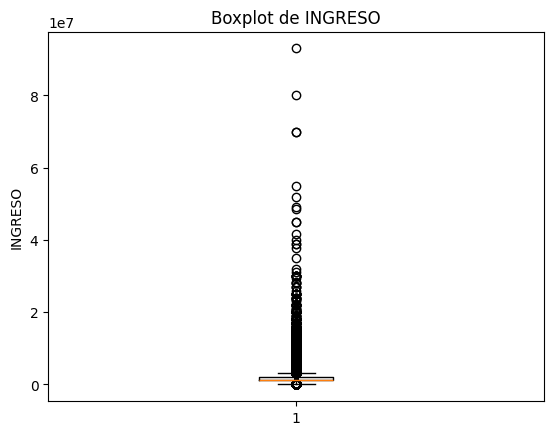

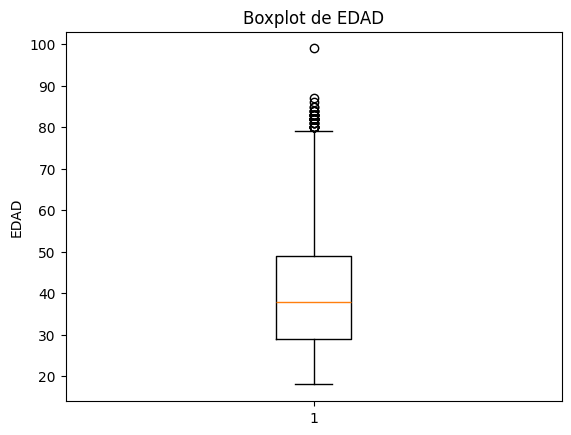

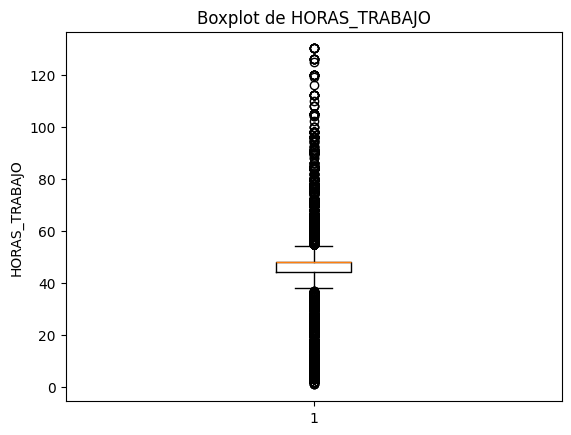

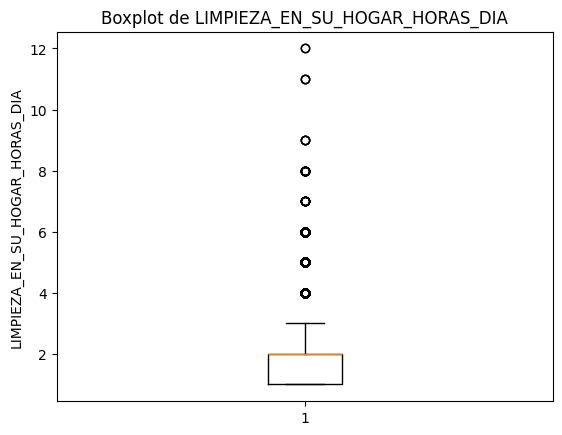

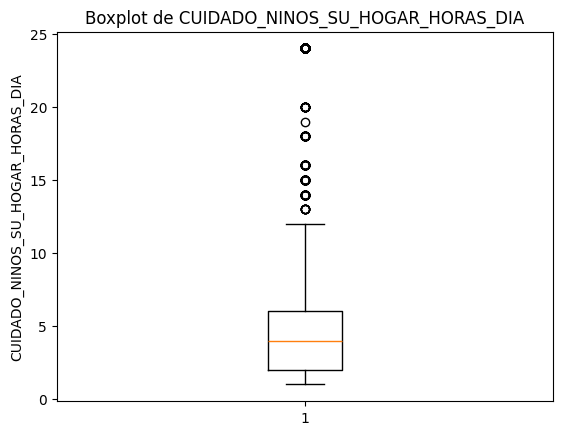

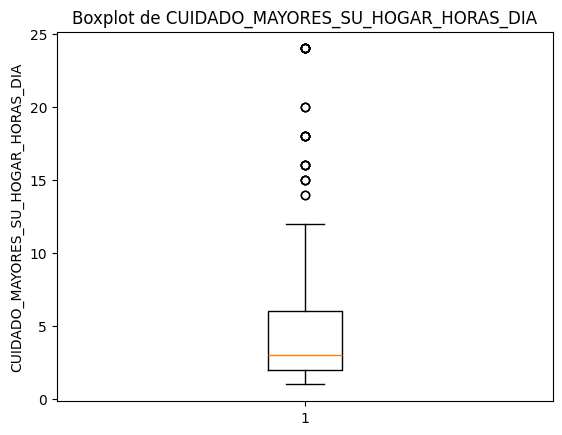

In [194]:
for var in vars_num:
    serie = df[var].dropna()
    plt.figure()
    plt.boxplot(serie)
    plt.title(f"Boxplot de {var}")
    plt.ylabel(var)
    plt.show()

In [195]:
# OUTLIERS DE HORAS(posiblemente negativos)
cols_horas = [
    'HORAS_TRABAJO',
    'LIMPIEZA_EN_SU_HOGAR_HORAS_DIA',
    'CUIDADO_NINOS_SU_HOGAR_HORAS_DIA',
    'CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA'
]

for col in cols_horas:
    n_neg = (df[col] < 0).sum()
    print(f"{col}: {n_neg} valores negativos")


HORAS_TRABAJO: 0 valores negativos
LIMPIEZA_EN_SU_HOGAR_HORAS_DIA: 0 valores negativos
CUIDADO_NINOS_SU_HOGAR_HORAS_DIA: 0 valores negativos
CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA: 0 valores negativos


In [196]:
# OUTLIERS DE EDAD

# Límite superior calculado
limite_sup = df['EDAD'].quantile(0.75) + 1.5 * (df['EDAD'].quantile(0.75) - df['EDAD'].quantile(0.25))
print("Límite superior para outliers en EDAD:", limite_sup)

# Filtrar edades > límite
edades_muy_altas = df[df['EDAD'] > limite_sup]

# Cuántas son y muestras
print(f"Total de casos con EDAD > {limite_sup:.1f} años:", edades_muy_altas.shape[0])
print(edades_muy_altas[['EDAD']].sort_values('EDAD').head(10))


Límite superior para outliers en EDAD: 79.0
Total de casos con EDAD > 79.0 años: 43
       EDAD
10024    80
10961    80
52011    80
78258    80
70879    80
72353    80
50697    80
99994    80
51638    81
1999     81


Resumen de log(INGRESO + 1):
count    59981.000
mean        14.180
std          0.787
min          0.000
25%         14.039
50%         14.078
75%         14.509
max         18.348
Name: log_INGRESO, dtype: float64


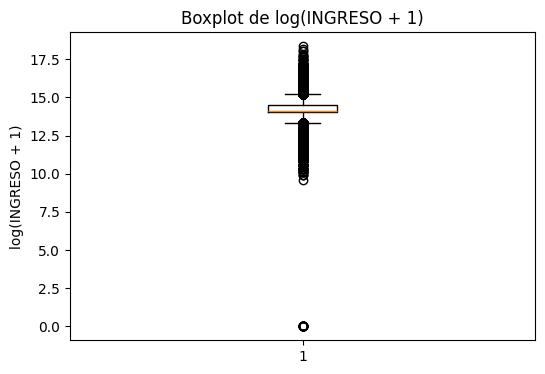

In [197]:
# 1) Transformación logarítmica de INGRESO
df_final['log_INGRESO'] = np.log1p(df_final['INGRESO'])

# 2) Resumen estadístico
print("Resumen de log(INGRESO + 1):")
print(df_final['log_INGRESO'].describe())

# 3) Boxplot para visualizar outliers en escala log
plt.figure(figsize=(6,4))
plt.boxplot(df_final['log_INGRESO'].dropna())
plt.title("Boxplot de log(INGRESO + 1)")
plt.ylabel("log(INGRESO + 1)")
plt.show()

In [198]:

# ----------------------------------------------------------
# One Hot Encoding para todas las variables categóricas
# ----------------------------------------------------------
categorical_vars = [
    'GENERO',
    'ETNIA',
    'DPTO',
    'MAXIMO_NIVEL_EDUCATIVO',
    'URBANO_RURAL',
    'POSICION_OCUPACIONAL',
    'GRUPO_INDIGENA',
    'SECTOR_DETALLADO',
    'SECTOR_AMPLIO',
    'TERMINO_CONTRATO',
    'TIPO_VIVIENDA',
    'TENENCIA_VIVIENDA',
    'CONTRATO_VERBAL_ESCRITO'
]

# Filtrar solo las que existan en df
categorical_vars = [col for col in categorical_vars if col in df.columns]

# Aplicar One Hot Encoding y reemplazar df
df = pd.get_dummies(df, columns=categorical_vars, drop_first=True)

# ----------------------------------------------------------
# Conversión de variables binarias (1="sí", 2="no") a 0/1
# ----------------------------------------------------------
binary_vars = [
    'EXISTENCIA_CONTRATO',
    'ELECTRICIDAD',
    'ACUEDUCTO',
    'GAS_NATURAL',
    'ALCANTARILLADO',
    'AGUA_POTABLE',
    'SABE_LEER',
    'ACTUALMENTE_ESTUDIA'
]

binary_vars = [col for col in binary_vars if col in df.columns]
df[binary_vars] = df[binary_vars].replace({1: 1, 2: 0})

# ----------------------------------------------------------
# Estandarización de variables numéricas
# ----------------------------------------------------------
numeric_vars = [
    'EDAD',
    'HORAS_TRABAJO',
    'TOTAL_PERSONAS_HOGAR',
    'ESTRATO',
    'LIMPIEZA_EN_SU_HOGAR_HORAS_DIA',
    'CUIDADO_MAYORES_SU_HOGAR_HORAS_DIA',
    'CUIDADO_NINOS_SU_HOGAR_HORAS_DIA'
]

numeric_vars = [col for col in numeric_vars if col in df.columns]
scaler = StandardScaler()
df[numeric_vars] = scaler.fit_transform(df[numeric_vars])

# ----------------------------------------------------------
# Verificación final
# ----------------------------------------------------------
print(f"Shape after encoding & scaling: {df.shape}")
print("Example dummy columns:", [c for c in df.columns if 'GENERO_' in c][:5])


Shape after encoding & scaling: (59981, 780)
Example dummy columns: ['GENERO_LABEL', 'GENERO_2.0', 'GENERO_3.0', 'GENERO_4.0']


In [199]:
#a

### **Sección 4: Modelado Predictivo y Evaluación**

In [200]:
# ───────────────────────────────────────────────
# Regresión Lineal con métricas ampliadas + clasificación de “alto ingreso”
# ───────────────────────────────────────────────

# 1) Prepara y limpia df
df_ingreso = df_final.copy()
df_lin = df_ingreso.copy()
df_lin = df_lin.loc[:, ~df_lin.columns.duplicated()]     # borrar duplicados
df_lin = df_lin.dropna(subset=['INGRESO'])               # sin NaN en el target

# 2) Selecciona tus 8 features + target
FEATURES = [
    'EDAD',
    'SEXO_NACIMIENTO',
    'ETNIA',
    'DPTO',                     # región
    'MAXIMO_NIVEL_EDUCATIVO',
    'OCUPACION',
    'EXISTENCIA_CONTRATO',      # tipo de contrato
    'HORAS_TRABAJO'
]
TARGET = 'INGRESO'

X = df_lin[FEATURES].copy()
y = df_lin[TARGET]

# 3) Homogeneiza las categóricas como strings
cat_feats = ['SEXO_NACIMIENTO','ETNIA','DPTO',
             'MAXIMO_NIVEL_EDUCATIVO','OCUPACION','EXISTENCIA_CONTRATO']
for c in cat_feats:
    X[c] = X[c].astype(str)

# 4) Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 5) Preprocesador: escalar numéricas y One-Hot codificar categóricas
num_feats = ['EDAD','HORAS_TRABAJO']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(),                 num_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_feats)
])

# 6) Pipeline de Regresión Lineal
pipeline_lr = Pipeline([
    ('pre',   preprocessor),
    ('model', LinearRegression())
])

# 7) Entrenar
pipeline_lr.fit(X_train, y_train)

# 8) Predecir
y_pred = pipeline_lr.predict(X_test)

# 9) Métricas de regresión
metrics = {
    'Score (R²)':            pipeline_lr.score(X_test, y_test),
    'Explained Variance':    explained_variance_score(y_test, y_pred),
    'RMSE':                  np.sqrt(mean_squared_error(y_test, y_pred)),
    'MAE':                   mean_absolute_error(y_test, y_pred),
    'Median AE':             median_absolute_error(y_test, y_pred),
    'Max Error':             max_error(y_test, y_pred),
    'MAPE (%)':              mean_absolute_percentage_error(y_test, y_pred) * 100
}
metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Value'])
print("=== Métricas de Regresión Lineal ===")
print(metrics_df)

# 10) Clasificación de “alto ingreso” vs “bajo ingreso”
umbral = y_train.median()
y_test_cl = (y_test > umbral).astype(int)
y_pred_cl = (y_pred > umbral).astype(int)

print("\n=== Classification Report (alto vs bajo ingreso) ===")
print(classification_report(
    y_test_cl,
    y_pred_cl,
    target_names=['<= mediana','> mediana']
))

print("Matriz de confusión:")
print(confusion_matrix(y_test_cl, y_pred_cl))


=== Métricas de Regresión Lineal ===
                        Value
Score (R²)          4.030e-01
Explained Variance  4.031e-01
RMSE                1.610e+06
MAE                 6.704e+05
Median AE           3.609e+05
Max Error           6.486e+07
MAPE (%)            4.428e+20

=== Classification Report (alto vs bajo ingreso) ===
              precision    recall  f1-score   support

  <= mediana       0.85      0.59      0.69      6625
   > mediana       0.63      0.87      0.73      5372

    accuracy                           0.71     11997
   macro avg       0.74      0.73      0.71     11997
weighted avg       0.75      0.71      0.71     11997

Matriz de confusión:
[[3891 2734]
 [ 708 4664]]


In [201]:
# ───────────────────────────────────────────────
# Random Forest Regressor con métricas de regresión y clasificación
# ───────────────────────────────────────────────

# 1) Prepara y limpia el DataFrame
df_rf = df_ingreso.copy()
df_rf = df_rf.loc[:, ~df_rf.columns.duplicated()]   # eliminar duplicados
df_rf = df_rf.dropna(subset=['INGRESO'])             # eliminar filas sin target

# 2) Define features y target
FEATURES = [
    'EDAD',
    'SEXO_NACIMIENTO',
    'ETNIA',
    'DPTO',
    'MAXIMO_NIVEL_EDUCATIVO',
    'OCUPACION',
    'EXISTENCIA_CONTRATO',
    'HORAS_TRABAJO'
]
TARGET = 'INGRESO'

X = df_rf[FEATURES].copy()
y = df_rf[TARGET]

# 3) Asegura que las categóricas sean strings
cat_feats = [
    'SEXO_NACIMIENTO','ETNIA','DPTO',
    'MAXIMO_NIVEL_EDUCATIVO','OCUPACION','EXISTENCIA_CONTRATO'
]
for c in cat_feats:
    X[c] = X[c].astype(str)

# 4) División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 5) Preprocesador: escalar numéricas y one‐hot encodear categóricas
num_feats = ['EDAD','HORAS_TRABAJO']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_feats)
])

# 6) Pipeline con RandomForestRegressor
rf_pipeline = Pipeline([
    ('pre',   preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=100,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ))
])

# 7) Entrena
rf_pipeline.fit(X_train, y_train)

# 8) Predice
y_pred = rf_pipeline.predict(X_test)

# 9) Métricas de regresión
r2   = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)

print("=== Métricas de Regresión (RF) ===")
print(f"R²   : {r2:.3f}")
print(f"RMSE : {rmse:,.0f} COP")
print(f"MAE  : {mae:,.0f} COP\n")

# 10) Clasificación “alto vs bajo ingreso” usando mediana de train
threshold = y_train.median()
y_test_cl = (y_test > threshold).astype(int)
y_pred_cl = (y_pred > threshold).astype(int)

accuracy = accuracy_score(y_test_cl, y_pred_cl)
report   = classification_report(
    y_test_cl, 
    y_pred_cl, 
    target_names=['<= mediana', '> mediana']
)
cm = confusion_matrix(y_test_cl, y_pred_cl)

print("=== Métricas de Clasificación (RF) ===")
print(f"Accuracy : {accuracy:.2f}\n")
print("Classification Report:")
print(report)
print("Matriz de confusión:")
print(cm)


KeyboardInterrupt: 

In [ ]:
# ───────────────────────────────────────────────
# Validación cruzada completa – Random Forest Regressor
# ───────────────────────────────────────────────


# 1) Prepara tus datos (todo el df, sin split)
df_cv = df_ingreso.copy()
df_cv = df_cv.loc[:, ~df_cv.columns.duplicated()]
df_cv = df_cv.dropna(subset=['INGRESO'])

FEATURES = [
    'EDAD',
    'SEXO_NACIMIENTO',
    'ETNIA',
    'DPTO',
    'MAXIMO_NIVEL_EDUCATIVO',
    'OCUPACION',
    'EXISTENCIA_CONTRATO',
    'HORAS_TRABAJO'
]
X = df_cv[FEATURES].copy()
y = df_cv['INGRESO']

# Asegura categorías como str
cat_feats = [
    'SEXO_NACIMIENTO','ETNIA','DPTO',
    'MAXIMO_NIVEL_EDUCATIVO','OCUPACION','EXISTENCIA_CONTRATO'
]
for c in cat_feats:
    X[c] = X[c].astype(str)

# 2) Define el preprocesador
num_feats = ['EDAD','HORAS_TRABAJO']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_feats)
])

# 3) Monta el pipeline con RandomForestRegressor
rf_pipeline = Pipeline([
    ('pre',   preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=100,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ))
])

# 4) Genera predicciones out‐of‐fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
y_pred_cv = cross_val_predict(rf_pipeline, X, y, cv=kf, n_jobs=-1)

# 5) Cálculo de métricas de regresión
r2   = r2_score(y, y_pred_cv)
rmse = np.sqrt(mean_squared_error(y, y_pred_cv))
mae  = mean_absolute_error(y, y_pred_cv)

print("=== CV Regression Metrics (RF) ===")
print(f"R²   : {r2:.3f}")
print(f"RMSE : {rmse:,.0f} COP")
print(f"MAE  : {mae:,.0f} COP\n")

# 6) Conversión a clasificación (umbral = mediana del target)
threshold = y.median()
y_true_cl = (y > threshold).astype(int)
y_pred_cl = (y_pred_cv > threshold).astype(int)

acc    = accuracy_score(y_true_cl, y_pred_cl)
report = classification_report(
    y_true_cl, y_pred_cl,
    target_names=['<= mediana', '> mediana']
)
cm     = confusion_matrix(y_true_cl, y_pred_cl)

print("=== CV Classification Metrics (RF) ===")
print(f"Accuracy: {acc:.2f}\n")
print("Classification Report:")
print(report)
print("Confusion Matrix:")
print(cm)


KeyboardInterrupt: 

In [ ]:
# ───────────────────────────────────────────────
# Modelo 3: XGBoost Regressor con evaluación completa
# ───────────────────────────────────────────────

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBRegressor
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    accuracy_score,
    classification_report,
    confusion_matrix
)

# 1) Prepara y limpia el DataFrame
df_xgb = df_ingreso.copy()
df_xgb = df_xgb.loc[:, ~df_xgb.columns.duplicated()]
df_xgb = df_xgb.dropna(subset=['INGRESO'])

# 2) Define tus 8 features + target
FEATURES = [
    'EDAD',
    'SEXO_NACIMIENTO',
    'ETNIA',
    'DPTO',
    'MAXIMO_NIVEL_EDUCATIVO',
    'OCUPACION',
    'EXISTENCIA_CONTRATO',
    'HORAS_TRABAJO'
]
TARGET = 'INGRESO'
X = df_xgb[FEATURES].copy()
y = df_xgb[TARGET]

# 3) Convierte categóricas a str
cat_feats = ['SEXO_NACIMIENTO','ETNIA','DPTO',
             'MAXIMO_NIVEL_EDUCATIVO','OCUPACION','EXISTENCIA_CONTRATO']
for c in cat_feats:
    X[c] = X[c].astype(str)

# 4) División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 5) Preprocesador idéntico a modelos anteriores
num_feats = ['EDAD','HORAS_TRABAJO']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_feats)
])

# 6) Pipeline con XGBRegressor
xgb_pipeline = Pipeline([
    ('pre', preprocessor),
    ('model', XGBRegressor(
        n_estimators=200,      
        max_depth=6,           
        learning_rate=0.1,     
        random_state=42,
        objective='reg:squarederror',
        verbosity=1
    ))
])

# 7) Entrena el modelo
xgb_pipeline.fit(X_train, y_train)

# 8) Predice sobre el set de prueba
y_pred = xgb_pipeline.predict(X_test)

# 9) Métricas de regresión
r2   = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)

print("=== XGBoost Regressor Metrics ===")
print(f"R²   : {r2:.3f}")
print(f"RMSE : {rmse:,.0f} COP")
print(f"MAE  : {mae:,.0f} COP\n")

# 10) Clasificación de “alto” vs “bajo” ingreso (mediana train)
threshold = y_train.median()
y_test_cl = (y_test > threshold).astype(int)
y_pred_cl = (y_pred > threshold).astype(int)

accuracy = accuracy_score(y_test_cl, y_pred_cl)
report   = classification_report(
    y_test_cl, y_pred_cl,
    target_names=['<= mediana', '> mediana']
)
cm = confusion_matrix(y_test_cl, y_pred_cl)

print("=== XGBoost Classification Metrics ===")
print(f"Accuracy : {accuracy:.2f}\n")
print("Classification Report:")
print(report)
print("Matriz de confusión:")
print(cm)


=== XGBoost Regressor Metrics ===
R²   : 0.347
RMSE : 1,683,047 COP
MAE  : 625,656 COP

=== XGBoost Classification Metrics ===
Accuracy : 0.70

Classification Report:
              precision    recall  f1-score   support

  <= mediana       0.87      0.53      0.66      6625
   > mediana       0.61      0.91      0.73      5372

    accuracy                           0.70     11997
   macro avg       0.74      0.72      0.69     11997
weighted avg       0.76      0.70      0.69     11997

Matriz de confusión:
[[3498 3127]
 [ 506 4866]]


In [ ]:
# ──────────────────────────────────────────────────────────────
# Optimización y evaluación completa del modelo XGBoost Regressor
# ──────────────────────────────────────────────────────────────
# 1) Prepara los datos
df_xgb = df_ingreso.copy()
df_xgb = df_xgb.loc[:, ~df_xgb.columns.duplicated()]
df_xgb = df_xgb.dropna(subset=['INGRESO'])

FEATURES = [
    'EDAD', 'SEXO_NACIMIENTO', 'ETNIA', 'DPTO',
    'MAXIMO_NIVEL_EDUCATIVO', 'OCUPACION',
    'EXISTENCIA_CONTRATO', 'HORAS_TRABAJO'
]
X = df_xgb[FEATURES].copy()
y = df_xgb['INGRESO']

# Categorías a string
cat_feats = [
    'SEXO_NACIMIENTO', 'ETNIA', 'DPTO',
    'MAXIMO_NIVEL_EDUCATIVO', 'OCUPACION', 'EXISTENCIA_CONTRATO'
]
for c in cat_feats:
    X[c] = X[c].astype(str)

# 2) División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3) Preprocesador
num_feats = ['EDAD', 'HORAS_TRABAJO']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_feats)
])

# 4) Pipeline XGBoost
xgb_pipeline = Pipeline([
    ('pre', preprocessor),
    ('model', XGBRegressor(objective='reg:squarederror', random_state=42))
])

# 5) Espacio de hiperparámetros para búsqueda
param_dist = {
    'model__n_estimators': [100, 200, 300, 500],
    'model__max_depth': [3, 5, 7, 10],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__subsample': [0.7, 0.8, 1],
    'model__colsample_bytree': [0.6, 0.8, 1]
}

# 6) RandomizedSearchCV para optimizar parámetros
random_search = RandomizedSearchCV(
    xgb_pipeline, param_distributions=param_dist,
    n_iter=20, cv=3, scoring='neg_mean_squared_error',
    n_jobs=-1, random_state=42, verbose=1
)
random_search.fit(X_train, y_train)

# Mejor modelo
best_xgb = random_search.best_estimator_
print("Mejores hiperparámetros:", random_search.best_params_)

# 7) Predicción en test
y_pred = best_xgb.predict(X_test)

# 8) Evaluación de regresión
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\n=== Métricas XGBoost Optimizado (Regresión) ===")
print(f"R²   : {r2:.3f}")
print(f"RMSE : {rmse:,.0f} COP")
print(f"MAE  : {mae:,.0f} COP")

# 9) Clasificación alto/bajo ingreso
threshold = y_train.median()
y_test_cl = (y_test > threshold).astype(int)
y_pred_cl = (y_pred > threshold).astype(int)

accuracy = accuracy_score(y_test_cl, y_pred_cl)
report = classification_report(
    y_test_cl, y_pred_cl,
    target_names=['<= mediana', '> mediana']
)
cm = confusion_matrix(y_test_cl, y_pred_cl)

print("\n=== Métricas XGBoost Optimizado (Clasificación) ===")
print(f"Accuracy : {accuracy:.2f}")
print("\nClassification Report:\n", report)
print("Confusion Matrix:\n", cm)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejores hiperparámetros: {'model__subsample': 0.8, 'model__n_estimators': 300, 'model__max_depth': 5, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.8}

=== Métricas XGBoost Optimizado (Regresión) ===
R²   : 0.364
RMSE : 1,661,164 COP
MAE  : 635,059 COP

=== Métricas XGBoost Optimizado (Clasificación) ===
Accuracy : 0.68

Classification Report:
               precision    recall  f1-score   support

  <= mediana       0.87      0.50      0.64      6625
   > mediana       0.60      0.91      0.72      5372

    accuracy                           0.68     11997
   macro avg       0.73      0.70      0.68     11997
weighted avg       0.75      0.68      0.67     11997

Confusion Matrix:
 [[3332 3293]
 [ 508 4864]]


In [ ]:
# ──────────────────────────────────────────────────────────────
# XGBoost Regressor con validación cruzada (k-fold) y métricas completas
# ──────────────────────────────────────────────────────────────
# 1) Prepara el DataFrame completo
df_cv = df_ingreso.copy()
df_cv = df_cv.loc[:, ~df_cv.columns.duplicated()]
df_cv = df_cv.dropna(subset=['INGRESO'])

FEATURES = [
    'EDAD', 'SEXO_NACIMIENTO', 'ETNIA', 'DPTO',
    'MAXIMO_NIVEL_EDUCATIVO', 'OCUPACION',
    'EXISTENCIA_CONTRATO', 'HORAS_TRABAJO'
]
X = df_cv[FEATURES].copy()
y = df_cv['INGRESO']

# 2) Homogeneiza categóricas a str
cat_feats = [
    'SEXO_NACIMIENTO','ETNIA','DPTO',
    'MAXIMO_NIVEL_EDUCATIVO','OCUPACION','EXISTENCIA_CONTRATO'
]
for c in cat_feats:
    X[c] = X[c].astype(str)

# 3) Define preprocesador
num_feats = ['EDAD','HORAS_TRABAJO']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_feats)
])

# 4) Monta pipeline con XGBoost
pipeline = Pipeline([
    ('pre', preprocessor),
    ('model', XGBRegressor(
        objective='reg:squarederror',
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbosity=0
    ))
])

# 5) Validación cruzada (5 folds) – regresión
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'R2': 'r2',
    'MSE': 'neg_mean_squared_error',
    'MAE': 'neg_mean_absolute_error'
}
cv_results = cross_validate(
    pipeline, X, y,
    cv=kf,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=False
)

# Convierte MSE/MAE negativas a positivas y RMSE
r2_scores   = cv_results['test_R2']
rmse_scores = np.sqrt(-cv_results['test_MSE'])
mae_scores  = -cv_results['test_MAE']

cv_df = pd.DataFrame({
    'R2':   r2_scores,
    'RMSE': rmse_scores,
    'MAE':  mae_scores
})
print("=== CV Regresión (5-fold) ===")
print(cv_df)
print("\nMedia:", cv_df.mean().to_dict())
print("Std  :", cv_df.std().to_dict())

# 6) Predicciones out-of-fold para clasificación
y_pred_cv = cross_val_predict(pipeline, X, y, cv=kf, n_jobs=-1)

# 7) Clasifica según mediana del target
threshold = y.median()
y_true_cl = (y > threshold).astype(int)
y_pred_cl = (y_pred_cv > threshold).astype(int)

acc    = accuracy_score(y_true_cl, y_pred_cl)
report = classification_report(
    y_true_cl, y_pred_cl,
    target_names=['<= mediana', '> mediana']
)
cm     = confusion_matrix(y_true_cl, y_pred_cl)

print("\n=== CV Clasificación (alto vs bajo ingreso) ===")
print(f"Accuracy: {acc:.2f}")
print("\nClassification Report:\n", report)
print("Confusion Matrix:\n", cm)


=== CV Regresión (5-fold) ===
      R2       RMSE         MAE
0  0.348  1.682e+06  628473.120
1  0.498  1.353e+06  601832.190
2  0.473  1.390e+06  584343.330
3  0.372  1.700e+06  612358.780
4  0.421  1.554e+06  606856.532

Media: {'R2': 0.42232304329809567, 'RMSE': 1535827.2928235228, 'MAE': 606772.7903981246}
Std  : {'R2': 0.06382514312992879, 'RMSE': 160598.222158617, 'MAE': 16043.728153671289}

=== CV Clasificación (alto vs bajo ingreso) ===
Accuracy: 0.70

Classification Report:
               precision    recall  f1-score   support

  <= mediana       0.87      0.53      0.66     33240
   > mediana       0.61      0.90      0.73     26741

    accuracy                           0.70     59981
   macro avg       0.74      0.72      0.69     59981
weighted avg       0.75      0.70      0.69     59981

Confusion Matrix:
 [[17737 15503]
 [ 2701 24040]]


In [ ]:
# ──────────────────────────────────────────────────────────────
# XGBoost con K-Fold manual y todas las métricas (regresión + clasificación)
# ──────────────────────────────────────────────────────────────

# 1) Prepara el DataFrame
df_kf = df_ingreso.copy()
df_kf = df_kf.loc[:, ~df_kf.columns.duplicated()]
df_kf = df_kf.dropna(subset=['INGRESO'])

FEATURES = [
    'EDAD', 'SEXO_NACIMIENTO', 'ETNIA', 'DPTO',
    'MAXIMO_NIVEL_EDUCATIVO', 'OCUPACION',
    'EXISTENCIA_CONTRATO', 'HORAS_TRABAJO'
]
X = df_kf[FEATURES].copy()
y = df_kf['INGRESO']

# Convertir categóricas a str
cat_feats = [
    'SEXO_NACIMIENTO','ETNIA','DPTO',
    'MAXIMO_NIVEL_EDUCATIVO','OCUPACION','EXISTENCIA_CONTRATO'
]
for c in cat_feats:
    X[c] = X[c].astype(str)

# 2) Preprocesador
num_feats = ['EDAD','HORAS_TRABAJO']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_feats)
])

# 3) K-Fold setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 4) Almacenar resultados
records = []

# 5) Loop por fold
for fold, (train_idx, test_idx) in enumerate(kf.split(X), start=1):
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]
    
    # Preprocesar
    X_tr_p = preprocessor.fit_transform(X_tr)
    X_te_p = preprocessor.transform(X_te)
    
    # Entrenar XGBoost
    model = XGBRegressor(
        objective='reg:squarederror',
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbosity=0
    )
    model.fit(X_tr_p, y_tr)
    
    # Predicciones
    y_pred = model.predict(X_te_p)
    
    # 5.1) Métricas de regresión
    r2    = r2_score(y_te, y_pred)
    ev    = explained_variance_score(y_te, y_pred)
    rmse  = np.sqrt(mean_squared_error(y_te, y_pred))
    mae   = mean_absolute_error(y_te, y_pred)
    medae = median_absolute_error(y_te, y_pred)
    mxerr = max_error(y_te, y_pred)
    mape  = mean_absolute_percentage_error(y_te, y_pred) * 100
    
    # 5.2) Métricas de clasificación (alto vs bajo por mediana de train)
    thresh = y_tr.median()
    y_te_cl   = (y_te > thresh).astype(int)
    y_pred_cl = (y_pred > thresh).astype(int)
    acc      = accuracy_score(y_te_cl, y_pred_cl)
    # condensar classification_report en dict (solo f1-score por clase)
    clf_report = classification_report(
        y_te_cl, y_pred_cl, output_dict=True
    )
    cm = confusion_matrix(y_te_cl, y_pred_cl)
    
    # Guardar
    records.append({
        'fold': fold,
        # regresión
        'R2': r2,
        'ExplainedVar': ev,
        'RMSE': rmse,
        'MAE': mae,
        'MedianAE': medae,
        'MaxError': mxerr,
        'MAPE(%)': mape,
        # clasificación
        'Accuracy': acc,
        'Precision_low': clf_report['0']['precision'],
        'Recall_low':    clf_report['0']['recall'],
        'F1_low':        clf_report['0']['f1-score'],
        'Precision_high':clf_report['1']['precision'],
        'Recall_high':   clf_report['1']['recall'],
        'F1_high':       clf_report['1']['f1-score'],
        'TN': cm[0,0],
        'FP': cm[0,1],
        'FN': cm[1,0],
        'TP': cm[1,1],
    })

# 6) DataFrame de resultados
results_df = pd.DataFrame(records).set_index('fold')

# 7) Mostrar por fold y resumen
pd.set_option('display.precision', 3)
print("=== Métricas por fold ===")
print(results_df)

print("\n=== Promedios ===")
print(results_df.mean().to_frame('mean').T)

print("\n=== Desviaciones estándar ===")
print(results_df.std().to_frame('std').T)


=== Métricas por fold ===
         R2  ExplainedVar       RMSE         MAE    MedianAE   MaxError  \
fold                                                                      
1     0.356         0.357  1.671e+06  627752.390  268983.375  6.546e+07   
2     0.488         0.488  1.366e+06  601604.967  271376.250  3.763e+07   
3     0.467         0.467  1.398e+06  587785.015  268304.562  6.522e+07   
4     0.360         0.360  1.716e+06  614405.377  274513.750  8.782e+07   
5     0.413         0.413  1.564e+06  610023.643  266138.938  6.531e+07   

        MAPE(%)  Accuracy  Precision_low  Recall_low  F1_low  Precision_high  \
fold                                                                           
1     3.887e+20     0.698          0.870       0.532   0.660           0.610   
2     1.929e+20     0.696          0.862       0.532   0.658           0.611   
3     2.658e+20     0.700          0.872       0.543   0.670           0.608   
4     3.712e+20     0.695          0.874       0

In [ ]:
# ──────────────────────────────────────────────────────────────
# Modelo XGBClassifier para “alto” vs “bajo” ingreso con balance y umbral optimizado
# ──────────────────────────────────────────────────────────────
# 1) Prepara y limpia el DataFrame
df = df_ingreso.copy()
df = df.loc[:, ~df.columns.duplicated()]
df = df.dropna(subset=['INGRESO'])

# 2) Define features y variable binaria
FEATURES = [
    'EDAD', 'SEXO_NACIMIENTO', 'ETNIA', 'DPTO',
    'MAXIMO_NIVEL_EDUCATIVO', 'OCUPACION',
    'EXISTENCIA_CONTRATO', 'HORAS_TRABAJO'
]
X = df[FEATURES].copy()
y_cont = df['INGRESO']
y = (y_cont > y_cont.median()).astype(int)  # 1 = alto ingreso, 0 = bajo

# 3) Asegura que las categóricas sean str
cat_feats = [
    'SEXO_NACIMIENTO','ETNIA','DPTO',
    'MAXIMO_NIVEL_EDUCATIVO','OCUPACION','EXISTENCIA_CONTRATO'
]
for c in cat_feats:
    X[c] = X[c].astype(str)

# 4) División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 5) Preprocesador
num_feats = ['EDAD','HORAS_TRABAJO']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_feats)
])

# 6) Calcula scale_pos_weight para balancear clases
n_neg = np.sum(y_train == 0)
n_pos = np.sum(y_train == 1)
scale_pos_weight = n_neg / n_pos

# 7) Pipeline con XGBClassifier
clf_pipeline = Pipeline([
    ('pre', preprocessor),
    ('model', XGBClassifier(
        objective='binary:logistic',
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        verbosity=0
    ))
])

# 8) Entrena el clasificador
clf_pipeline.fit(X_train, y_train)

# 9) Predice probabilidades en test
y_prob = clf_pipeline.predict_proba(X_test)[:, 1]

# 10) Optimiza umbral a partir de la curva Precision-Recall
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * precisions * recalls / (precisions + recalls + 1e-12)
best_idx = np.argmax(f1_scores)
opt_threshold = thresholds[best_idx]

# 11) Predicción final con umbral optimizado
y_pred = (y_prob >= opt_threshold).astype(int)

# 12) Métricas de clasificación
acc   = accuracy_score(y_test, y_pred)
report = classification_report(
    y_test, y_pred,
    target_names=['<= mediana', '> mediana']
)
cm = confusion_matrix(y_test, y_pred)

print("Umbral óptimo (max F1):", opt_threshold)
print(f"Accuracy: {acc:.2f}\n")
print("Classification Report:\n", report)
print("Confusion Matrix:\n", cm)


Umbral óptimo (max F1): 0.44934145
Accuracy: 0.77

Classification Report:
               precision    recall  f1-score   support

  <= mediana       0.82      0.76      0.79      6648
   > mediana       0.72      0.80      0.76      5349

    accuracy                           0.77     11997
   macro avg       0.77      0.78      0.77     11997
weighted avg       0.78      0.77      0.77     11997

Confusion Matrix:
 [[5027 1621]
 [1088 4261]]


In [ ]:
# ──────────────────────────────────────────────────────────────
# Validación Cruzada de XGBClassifier con umbral optimizado
# ──────────────────────────────────────────────────────────────
# 1) Prepara los datos
df = df_ingreso.copy()
df = df.loc[:, ~df.columns.duplicated()]
df = df.dropna(subset=['INGRESO'])

FEATURES = [
    'EDAD', 'SEXO_NACIMIENTO', 'ETNIA', 'DPTO',
    'MAXIMO_NIVEL_EDUCATIVO', 'OCUPACION',
    'EXISTENCIA_CONTRATO', 'HORAS_TRABAJO'
]
X = df[FEATURES].copy()
y_cont = df['INGRESO']
y = (y_cont > y_cont.median()).astype(int)

# Asegura que las categóricas sean str
cat_feats = [
    'SEXO_NACIMIENTO','ETNIA','DPTO',
    'MAXIMO_NIVEL_EDUCATIVO','OCUPACION','EXISTENCIA_CONTRATO'
]
for c in cat_feats:
    X[c] = X[c].astype(str)

# 2) Preprocesador
num_feats = ['EDAD','HORAS_TRABAJO']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_feats)
])

# 3) Pipeline de clasificación
clf = Pipeline([
    ('pre', preprocessor),
    ('model', XGBClassifier(
        objective='binary:logistic',
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=(y==0).sum()/(y==1).sum(),
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        verbosity=0
    ))
])

# 4) Out-of-fold probabilidades
kf = KFold(n_splits=5, shuffle=True, random_state=42)
y_prob_cv = cross_val_predict(
    clf, X, y, cv=kf,
    method='predict_proba', n_jobs=-1
)[:,1]

# 5) Encuentra umbral óptimo sobre todas las folds
precisions, recalls, thresholds = precision_recall_curve(y, y_prob_cv)
f1_scores = 2 * precisions * recalls / (precisions + recalls + 1e-12)
best = np.argmax(f1_scores)
opt_threshold = thresholds[best]

# 6) Predicción final y métricas
y_pred_cv = (y_prob_cv >= opt_threshold).astype(int)
acc = accuracy_score(y, y_pred_cv)
report = classification_report(
    y, y_pred_cv,
    target_names=['<= mediana','> mediana']
)
cm = confusion_matrix(y, y_pred_cv)

print(f"Umbral óptimo (max F1): {opt_threshold:.3f}")
print(f"Accuracy CV: {acc:.2f}\n")
print("Classification Report CV:\n", report)
print("Confusion Matrix CV:\n", cm)


Umbral óptimo (max F1): 0.467
Accuracy CV: 0.78

Classification Report CV:
               precision    recall  f1-score   support

  <= mediana       0.82      0.77      0.80     33240
   > mediana       0.74      0.78      0.76     26741

    accuracy                           0.78     59981
   macro avg       0.78      0.78      0.78     59981
weighted avg       0.78      0.78      0.78     59981

Confusion Matrix CV:
 [[25759  7481]
 [ 5770 20971]]


In [ ]:
# ──────────────────────────────────────────────────────────────
# Predicción híbrida: Ingreso continuo + Clasificación según umbrales
# ──────────────────────────────────────────────────────────────
# ——— Supuestos ——————————————————————
# best_reg     : tu Pipeline de regresión entrenado (ej. preprocessor + XGBRegressor)
# FEATURES     : lista de las 8 variables usadas ['EDAD','SEXO_NACIMIENTO',…,'HORAS_TRABAJO']

# Definimos los umbrales socioeconómicos en COP (basados en DANE)
UMBRAL_BAJO = 1_200_000    # Entrada a clase media
UMBRAL_ALTO = 5_000_000    # Entrada a clase alta

def clasificar_ingreso(valor):
    if valor < UMBRAL_BAJO:
        return "bajo ingreso"
    elif valor < UMBRAL_ALTO:
        return "medio ingreso"
    else:
        return "alto ingreso"

def predict_ingreso_y_clase(input_dict, best_reg):
    """
    input_dict: dict con claves = FEATURES, valores = input del usuario.
    best_reg: pipeline regresor entrenado.
    """

    # 1) Pasa el dict a DataFrame (1 fila)
    df_in = pd.DataFrame([input_dict], columns=FEATURES)

    # 2) Asegura que las categóricas estén como string
    cat_feats = [c for c in FEATURES if c not in ['EDAD','HORAS_TRABAJO']]
    for c in cat_feats:
        df_in[c] = df_in[c].astype(str)

    # 3) Predicción continua
    ingreso_pred = best_reg.predict(df_in)[0]

    # 4) Clasificación socioeconómica
    clase_pred = clasificar_ingreso(ingreso_pred)

    return {
        'ingreso_predicho': float(ingreso_pred),
        'clase_predicha':    clase_pred,
        'umbrales_usados':   {'bajo': UMBRAL_BAJO, 'alto': UMBRAL_ALTO}
    }

# ──────────────────────────────────────────────────────────────
# Ejemplo de uso:
# ──────────────────────────────────────────────────────────────

user_input = {
    'EDAD': 40,
    'SEXO_NACIMIENTO': '1',  # Hombre
    'ETNIA': '6',            # Ninguno
    'DPTO': '11',            # Bogotá
    'MAXIMO_NIVEL_EDUCATIVO': '12',  # Maestría
    'OCUPACION': '1',        # Directores y gerentes
    'EXISTENCIA_CONTRATO': '1',
    'HORAS_TRABAJO': 50
}

resultado = predict_ingreso_y_clase(
    user_input,
    best_reg=best_xgb  # tu modelo entrenado y guardado
)

print("Resultado de la predicción:")
print(f" • Ingreso mensual estimado: {resultado['ingreso_predicho']:.0f} COP")
print(f" • Clase socioeconómica: {resultado['clase_predicha']}")


Resultado de la predicción:
 • Ingreso mensual estimado: 1904580 COP
 • Clase socioeconómica: medio ingreso


In [ ]:
# Guarda el modelo
model_file = joblib.dump(best_xgb, "modelo_hibrido.pkl")
print("Modelo guardado en:", model_file)


Modelo guardado en: ['modelo_hibrido.pkl']


Hasta Aqui vamos...

Lo que continua es solo referencia por si algo pasa ok? jaja

In [ ]:
# Solo si aparece:
df_total = df_total.rename(columns={'P6500':'INGRESO'})
print('INGRESO' in df_total.columns)   # debe ser True


True


In [ ]:
import sys
!{sys.executable} -m pip install --upgrade matplotlib seaborn

In [ ]:

# 1) Subconjunto con las variables numéricas
num_vars = [
    "ingreso_mensual", "ingreso_horas_extras", "pago_especie_alimentos",
    "pago_especie_vivienda", "pago_especie_otros", "subsidio_alimentacion",
    "subsidio_transporte", "subsidio_familiar", "subsidio_educativo",
    "prima_navidad", "prima_vacaciones", "bonificacion_antiguedad",
    "bonificacion_productividad", "bonificacion_riesgo",
    "bonificacion_permanencia", "viaticos",
    "sexo",  "edad",  "etnia",  "departamento", "area_residencia",
    "tipo_cabecera", "nivel_educativo", "grado_nivel_educativo",
    "campo_estudio", "titulo_obtenido", "modalidad_titulo",
    "tiene_contrato", "contrato_escrito", "tipo_contrato",
    "medio_obtencion_empleo", "empresa_con_contabilidad",
    "forma_trabajo_semana", "lugar_nacimiento", "nacionalidad_exterior",
    "residencia_5m", "residencia_12m", "residencia_5a",
    "ingreso_arriendos_pensiones", "cesantias_derecho",
    "impuesto_predial", "impuesto_valorizacion", "impuesto_renta",
]

df_num = df_anual[num_vars].copy()

# 2) Describe: media, std, min, 25%, 50%, 75%, max
desc = df_num.describe().T

# 3) Añadimos sesgo (skewness) y curtosis (kurtosis)
desc["skewness"] = df_num.skew()
desc["kurtosis"] = df_num.kurt()

# 4) Mostramos todo
display(desc)


NameError: name 'df_anual' is not defined

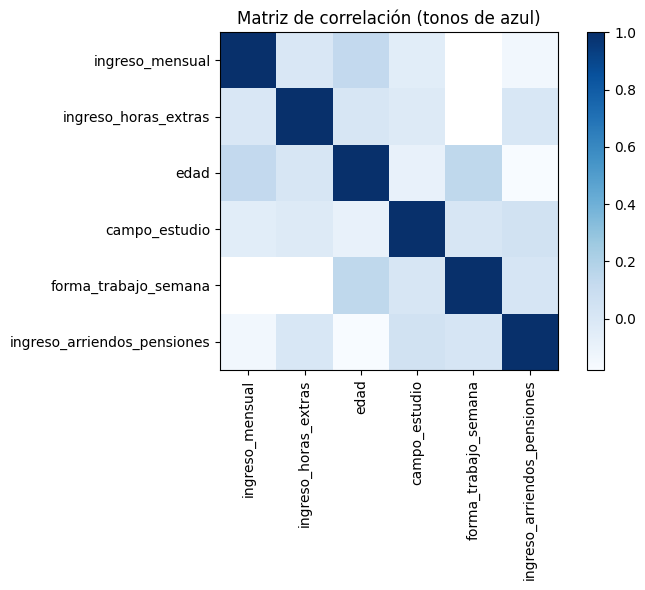

In [ ]:

corr = df_anual.select_dtypes(include=['int64','float64']).corr()
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.imshow(corr, cmap='Blues', interpolation='nearest')
fig.colorbar(cax)

ax.set_xticks(range(len(corr)))
ax.set_yticks(range(len(corr)))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.columns)
ax.set_title('Matriz de correlación (tonos de azul)')
plt.tight_layout()
plt.show()

In [ ]:
Q1 = df_anual['ingreso_mensual'].quantile(0.25)
Q3 = df_anual['ingreso_mensual'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQRs
upper = Q3 + 1.5 * IQR

outliers = df_anual[
    (df_anual['ingreso_mensual'] < lower) |
    (df_anual['ingreso_mensual'] > upper)
]
print(f"Número de outliers por IQR: {outliers.shape[0]}")


Número de outliers por IQR: 22677


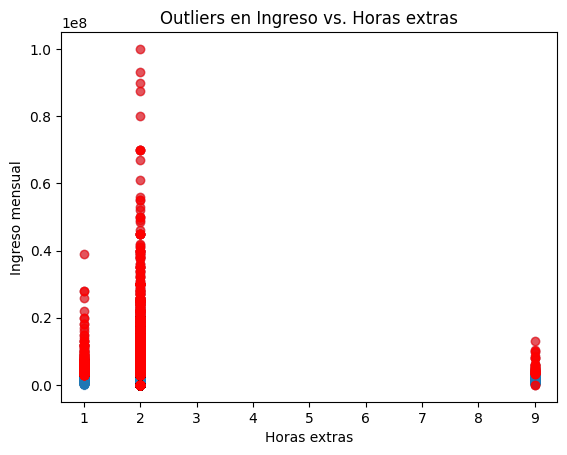

In [ ]:
plt.scatter(df_anual['ingreso_horas_extras'], df_anual['ingreso_mensual'], alpha=0.3)
plt.scatter(outliers['ingreso_horas_extras'], outliers['ingreso_mensual'], color='red', alpha=0.6)
plt.xlabel('Horas extras')
plt.ylabel('Ingreso mensual')
plt.title('Outliers en Ingreso vs. Horas extras')
plt.show()